<a href="https://colab.research.google.com/github/pmj-chosim/Commit-Project-2023.1.20-2023.2.28-/blob/main/2023.02.09/eeg/EEG_MotorImagery_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
pwd

'/content'

In [4]:
ls

drive/  sample_data/


In [11]:
data_path = '/content/drive/MyDrive/EEG_MI/s01.mat'

In [16]:
import scipy.io as sio
# Load the .mat file into a dictionary
mat_file = sio.loadmat(data_path)

In [17]:
len(mat_file['eeg'].item())

17

<img src = "https://drive.google.com/uc?id=1LqRzbtxNe0rGgNHMrGo0n8nZijirMM0r" height = 900 width = 700>

In [18]:
data  = mat_file['eeg'].item()
event = data[11][0]
imagery_left = data[7]
imagery_right = data[8]

In [19]:
imagery_left.shape

(68, 358400)

In [20]:
event_onset = []

for idx, i in enumerate(event):
  if i == 1:
    event_onset.append(idx)

print(event_onset) # 자극이 등장했을 때의 시간 정보보

[1023, 4607, 8191, 11775, 15359, 18943, 22527, 26111, 29695, 33279, 36863, 40447, 44031, 47615, 51199, 54783, 58367, 61951, 65535, 69119, 72703, 76287, 79871, 83455, 87039, 90623, 94207, 97791, 101375, 104959, 108543, 112127, 115711, 119295, 122879, 126463, 130047, 133631, 137215, 140799, 144383, 147967, 151551, 155135, 158719, 162303, 165887, 169471, 173055, 176639, 180223, 183807, 187391, 190975, 194559, 198143, 201727, 205311, 208895, 212479, 216063, 219647, 223231, 226815, 230399, 233983, 237567, 241151, 244735, 248319, 251903, 255487, 259071, 262655, 266239, 269823, 273407, 276991, 280575, 284159, 287743, 291327, 294911, 298495, 302079, 305663, 309247, 312831, 316415, 319999, 323583, 327167, 330751, 334335, 337919, 341503, 345087, 348671, 352255, 355839]


In [21]:
data_left, data_right = [] , []

for onset in event_onset:
  data_left.append(imagery_left[:,onset:onset+1024])
  data_right.append(imagery_right[:,onset:onset+1024]) #sampling rate가 512Hz 이기 때문에, 자극이 등장하고 나서 2초간의 데이터를 추출하기 위해선 1024개의 정보를 가져와야함함

In [22]:
data_left, data_right = np.array(data_left), np.array(data_right)
print(data_left.shape)

(100, 68, 1024)


In [23]:
y = [0] * 100 + [1] * 100
x = np.vstack((data_left,data_right))
print(x.shape, len(y))

(200, 68, 1024) 200


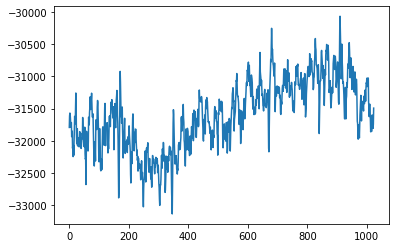

In [27]:
import matplotlib.pyplot as plt

plt.plot(data_left[0,0,:])

In [28]:
class EEGNet(nn.Module):
    def __init__(self):
        super(EEGNet, self).__init__()
        
        F1 = 8
        D = 2
        C = 68
        fs = 512
        F2 = F1 * D
        T = 2 * fs

        self.batchnorm0 = nn.BatchNorm2d(1)
        # Layer 1
        self.conv1 = nn.Conv2d(1, F1, (1,fs//2), padding = 'same',bias=False)
        self.batchnorm1 = nn.BatchNorm2d(F1)  
        # Layer 2
        self.conv2 = nn.Conv2d(F1, F1*D, (C, 1), groups=F1, bias=False)
        self.batchnorm2 = nn.BatchNorm2d(F1 * D)
        self.pooling2 = nn.AvgPool2d((1, 4)) 
        # Layer 3
        self.conv3 = nn.Conv2d(F1*D, F2, (1, 16), padding = 'same',bias=False)
        self.batchnorm3 = nn.BatchNorm2d(F2)
        self.pooling3 = nn.AvgPool2d((1, 8))    
        # FC Layer
        self.fc = nn.Linear((F2 * T)//32, 2)
     
    def forward(self, x):  

        x = self.batchnorm0(x)
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = F.elu(x)
        x = self.pooling2(x)
        x = F.dropout(x,0.5)
        x = self.conv3(x)
        x = self.batchnorm3(x)
        x = F.elu(x)
        x = self.pooling3(x)
        x = F.dropout(x,0.5)
        x = x.view(x.size(0),-1)
        x = self.fc(x)
        return x

class EEG_MI(Dataset):
    def __init__(self,data,label):
        
        self.data = data
        self.label = torch.FloatTensor(label)

    def __getitem__(self, index):
        x = self.data[index]
        y = self.label[index]
        return x, y
    
    def __len__(self):
        return len(self.data)

In [29]:
from sklearn.model_selection import train_test_split

# Convert your data into a PyTorch tensor
x = torch.from_numpy(x)

# Split the data into training and testing sets
train_data, test_data, train_labels, test_labels = train_test_split(x, y, test_size=0.2, random_state=42)

In [30]:
print(train_data.shape)

torch.Size([160, 68, 1024])


In [31]:
train_data, test_data = train_data.unsqueeze(1) , test_data.unsqueeze(1)

train_dataset, test_dataset = EEG_MI(train_data,train_labels) , EEG_MI(test_data,test_labels)
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = 16, shuffle=False)

In [32]:
train_loss, train_acc, test_loss, test_acc = [],[],[],[]

model = EEGNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = float(1e-4))

device = 'cuda:0'
model.to(device)

for epoch in tqdm(range(100)):
  running_loss = 0.0
  running_correct = 0.0
        
  #Train
  for data, target in train_loader:
    model.train()
    optimizer.zero_grad()
    outputs = model(data.to(device))
    target = target.type(torch.LongTensor)
    loss = criterion(outputs,target.to(device))
    loss.backward()
    optimizer.step()
    running_loss += loss.item() * data.size(0)
    _,preds = torch.max(outputs.data,dim=1)
    running_correct += torch.sum(target == preds.cpu().detach())
    print("loss:", running_loss / len(train_data))
    print("Acc:", running_correct.double() / len(train_data))

    model.eval()
    with torch.no_grad():
            
      running_loss = 0.0
      running_correct = 0.0
      cnt = 0
      
      for data,target in test_loader:

          outputs = model(data.to(device))
          target = target.type(torch.LongTensor)

          loss = criterion(outputs,target.to(device))
  
          running_loss += loss.item() * data.size(0)
          cnt += data.size(0)
          
          _,preds = torch.max(outputs.data,dim=1)

          running_correct += torch.sum(target == preds.cpu().detach())
          
      print("Test loss : %0.5f"%(running_loss/cnt))
      print("Test Acc : %0.3f "%(running_correct.double()/cnt))

  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch/nn/modules/conv.py:459: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:895.)
  return F.conv2d(input, weight, bias, self.stride,


loss: 0.06696691513061523
Acc: tensor(0.0625, dtype=torch.float64)
Test loss : 0.71329
Test Acc : 0.500 
loss: 0.25362650752067567
Acc: tensor(0.1812, dtype=torch.float64)
Test loss : 0.70587
Test Acc : 0.450 
loss: 0.2483000636100769
Acc: tensor(0.1437, dtype=torch.float64)
Test loss : 0.72236
Test Acc : 0.375 
loss: 0.2543993353843689
Acc: tensor(0.1187, dtype=torch.float64)
Test loss : 0.68386
Test Acc : 0.550 
loss: 0.2491608291864395
Acc: tensor(0.1688, dtype=torch.float64)
Test loss : 0.69080
Test Acc : 0.600 
loss: 0.23877772092819213
Acc: tensor(0.2125, dtype=torch.float64)
Test loss : 0.73950
Test Acc : 0.450 
loss: 0.25506078004837035
Acc: tensor(0.1688, dtype=torch.float64)
Test loss : 0.67549
Test Acc : 0.600 
loss: 0.23696281313896178
Acc: tensor(0.2000, dtype=torch.float64)
Test loss : 0.70702
Test Acc : 0.500 
loss: 0.24407899677753447
Acc: tensor(0.1812, dtype=torch.float64)
Test loss : 0.68593
Test Acc : 0.550 


  1%|          | 1/100 [00:10<17:43, 10.74s/it]

loss: 0.24437712132930756
Acc: tensor(0.1938, dtype=torch.float64)
Test loss : 0.71114
Test Acc : 0.500 
loss: 0.07687045931816101
Acc: tensor(0.0437, dtype=torch.float64)
Test loss : 0.71685
Test Acc : 0.425 
loss: 0.2480085551738739
Acc: tensor(0.1688, dtype=torch.float64)
Test loss : 0.67657
Test Acc : 0.525 
loss: 0.23281778991222382
Acc: tensor(0.2062, dtype=torch.float64)
Test loss : 0.69488
Test Acc : 0.525 
loss: 0.24791735410690308
Acc: tensor(0.1688, dtype=torch.float64)
Test loss : 0.68565
Test Acc : 0.600 
loss: 0.24545424282550812
Acc: tensor(0.1938, dtype=torch.float64)
Test loss : 0.67995
Test Acc : 0.575 
loss: 0.24157313108444214
Acc: tensor(0.1812, dtype=torch.float64)
Test loss : 0.66406
Test Acc : 0.600 
loss: 0.24056359231472016
Acc: tensor(0.2000, dtype=torch.float64)
Test loss : 0.72215
Test Acc : 0.425 
loss: 0.2479228377342224
Acc: tensor(0.1625, dtype=torch.float64)
Test loss : 0.68220
Test Acc : 0.450 
loss: 0.24730518758296965
Acc: tensor(0.1562, dtype=torch

  2%|▏         | 2/100 [00:14<10:55,  6.69s/it]

loss: 0.2467444509267807
Acc: tensor(0.2250, dtype=torch.float64)
Test loss : 0.67114
Test Acc : 0.625 
loss: 0.06846892833709717
Acc: tensor(0.0500, dtype=torch.float64)
Test loss : 0.71355
Test Acc : 0.425 
loss: 0.2429335355758667
Acc: tensor(0.1688, dtype=torch.float64)
Test loss : 0.72542
Test Acc : 0.350 
loss: 0.25025188028812406
Acc: tensor(0.1500, dtype=torch.float64)
Test loss : 0.70506
Test Acc : 0.525 
loss: 0.24198464453220367
Acc: tensor(0.2000, dtype=torch.float64)
Test loss : 0.72262
Test Acc : 0.450 
loss: 0.252137091755867
Acc: tensor(0.1688, dtype=torch.float64)
Test loss : 0.68886
Test Acc : 0.550 
loss: 0.2456976890563965
Acc: tensor(0.1812, dtype=torch.float64)
Test loss : 0.72459
Test Acc : 0.425 
loss: 0.25852629244327546
Acc: tensor(0.1500, dtype=torch.float64)
Test loss : 0.68545
Test Acc : 0.600 
loss: 0.23853662610054016
Acc: tensor(0.1938, dtype=torch.float64)
Test loss : 0.73762
Test Acc : 0.425 
loss: 0.2523748934268951
Acc: tensor(0.1625, dtype=torch.flo

  3%|▎         | 3/100 [00:18<08:43,  5.40s/it]

loss: 0.26777122020721433
Acc: tensor(0.1313, dtype=torch.float64)
Test loss : 0.69683
Test Acc : 0.550 
loss: 0.07144486904144287
Acc: tensor(0.0437, dtype=torch.float64)
Test loss : 0.67172
Test Acc : 0.600 
loss: 0.2386702209711075
Acc: tensor(0.1938, dtype=torch.float64)
Test loss : 0.67091
Test Acc : 0.625 
loss: 0.2468353033065796
Acc: tensor(0.2062, dtype=torch.float64)
Test loss : 0.69826
Test Acc : 0.475 
loss: 0.2379006952047348
Acc: tensor(0.1812, dtype=torch.float64)
Test loss : 0.69756
Test Acc : 0.525 
loss: 0.24767783880233765
Acc: tensor(0.1812, dtype=torch.float64)
Test loss : 0.71401
Test Acc : 0.500 
loss: 0.25316725075244906
Acc: tensor(0.1688, dtype=torch.float64)
Test loss : 0.71538
Test Acc : 0.500 
loss: 0.24108758568763733
Acc: tensor(0.1875, dtype=torch.float64)
Test loss : 0.73710
Test Acc : 0.475 
loss: 0.2653907209634781
Acc: tensor(0.1688, dtype=torch.float64)
Test loss : 0.74161
Test Acc : 0.425 
loss: 0.2502014398574829
Acc: tensor(0.1688, dtype=torch.fl

  4%|▍         | 4/100 [00:22<07:40,  4.80s/it]

loss: 0.24905993342399596
Acc: tensor(0.1500, dtype=torch.float64)
Test loss : 0.68513
Test Acc : 0.575 
loss: 0.0789999544620514
Acc: tensor(0.0500, dtype=torch.float64)
Test loss : 0.70375
Test Acc : 0.450 
loss: 0.2623763531446457
Acc: tensor(0.1437, dtype=torch.float64)
Test loss : 0.66113
Test Acc : 0.650 
loss: 0.23914371132850648
Acc: tensor(0.2125, dtype=torch.float64)
Test loss : 0.72893
Test Acc : 0.375 
loss: 0.25673391819000246
Acc: tensor(0.1437, dtype=torch.float64)
Test loss : 0.66822
Test Acc : 0.550 
loss: 0.2358339935541153
Acc: tensor(0.1875, dtype=torch.float64)
Test loss : 0.72885
Test Acc : 0.500 
loss: 0.24815222024917602
Acc: tensor(0.1812, dtype=torch.float64)
Test loss : 0.75793
Test Acc : 0.475 
loss: 0.2632119834423065
Acc: tensor(0.1688, dtype=torch.float64)
Test loss : 0.71181
Test Acc : 0.500 
loss: 0.24534876942634581
Acc: tensor(0.1812, dtype=torch.float64)
Test loss : 0.74455
Test Acc : 0.350 
loss: 0.2592873781919479
Acc: tensor(0.1250, dtype=torch.fl

  5%|▌         | 5/100 [00:26<07:05,  4.48s/it]

loss: 0.2638108491897583
Acc: tensor(0.1375, dtype=torch.float64)
Test loss : 0.74813
Test Acc : 0.475 
loss: 0.07982132434844971
Acc: tensor(0.0250, dtype=torch.float64)
Test loss : 0.69956
Test Acc : 0.550 
loss: 0.24340906441211702
Acc: tensor(0.1938, dtype=torch.float64)
Test loss : 0.70255
Test Acc : 0.525 
loss: 0.2541341036558151
Acc: tensor(0.1875, dtype=torch.float64)
Test loss : 0.71538
Test Acc : 0.500 
loss: 0.24029777348041534
Acc: tensor(0.1938, dtype=torch.float64)
Test loss : 0.69812
Test Acc : 0.575 
loss: 0.2437548369169235
Acc: tensor(0.2000, dtype=torch.float64)
Test loss : 0.70436
Test Acc : 0.550 
loss: 0.2436372935771942
Acc: tensor(0.1875, dtype=torch.float64)
Test loss : 0.73664
Test Acc : 0.500 
loss: 0.2523712903261185
Acc: tensor(0.1625, dtype=torch.float64)
Test loss : 0.73655
Test Acc : 0.375 
loss: 0.25664285719394686
Acc: tensor(0.1437, dtype=torch.float64)
Test loss : 0.70467
Test Acc : 0.575 
loss: 0.24501372873783112
Acc: tensor(0.1875, dtype=torch.fl

  6%|▌         | 6/100 [00:30<06:42,  4.29s/it]

loss: 0.25993408262729645
Acc: tensor(0.1437, dtype=torch.float64)
Test loss : 0.74320
Test Acc : 0.450 
loss: 0.06560510396957397
Acc: tensor(0.0875, dtype=torch.float64)
Test loss : 0.71566
Test Acc : 0.525 
loss: 0.24780893623828887
Acc: tensor(0.1875, dtype=torch.float64)
Test loss : 0.79329
Test Acc : 0.375 
loss: 0.2619258165359497
Acc: tensor(0.1562, dtype=torch.float64)
Test loss : 0.76747
Test Acc : 0.425 
loss: 0.2780463695526123
Acc: tensor(0.1375, dtype=torch.float64)
Test loss : 0.69852
Test Acc : 0.525 
loss: 0.2409056693315506
Acc: tensor(0.1875, dtype=torch.float64)
Test loss : 0.76215
Test Acc : 0.400 
loss: 0.2603523463010788
Acc: tensor(0.1562, dtype=torch.float64)
Test loss : 0.67410
Test Acc : 0.600 
loss: 0.24579643905162812
Acc: tensor(0.1875, dtype=torch.float64)
Test loss : 0.76526
Test Acc : 0.550 
loss: 0.2658317983150482
Acc: tensor(0.1750, dtype=torch.float64)
Test loss : 0.77699
Test Acc : 0.375 
loss: 0.2643973231315613
Acc: tensor(0.1375, dtype=torch.flo

  7%|▋         | 7/100 [00:34<06:28,  4.18s/it]

loss: 0.2666300892829895
Acc: tensor(0.1375, dtype=torch.float64)
Test loss : 0.74378
Test Acc : 0.400 
loss: 0.06732687950134278
Acc: tensor(0.0500, dtype=torch.float64)
Test loss : 0.70411
Test Acc : 0.425 
loss: 0.25242941081523895
Acc: tensor(0.1562, dtype=torch.float64)
Test loss : 0.72895
Test Acc : 0.450 
loss: 0.2705589532852173
Acc: tensor(0.1437, dtype=torch.float64)
Test loss : 0.71807
Test Acc : 0.500 
loss: 0.25564142167568205
Acc: tensor(0.1562, dtype=torch.float64)
Test loss : 0.77449
Test Acc : 0.500 
loss: 0.26636011302471163
Acc: tensor(0.1812, dtype=torch.float64)
Test loss : 0.71736
Test Acc : 0.500 
loss: 0.2485643059015274
Acc: tensor(0.1812, dtype=torch.float64)
Test loss : 0.82849
Test Acc : 0.325 
loss: 0.2829509794712067
Acc: tensor(0.1250, dtype=torch.float64)
Test loss : 0.83186
Test Acc : 0.475 
loss: 0.26569956839084624
Acc: tensor(0.2000, dtype=torch.float64)
Test loss : 0.78163
Test Acc : 0.500 
loss: 0.26325016021728515
Acc: tensor(0.1812, dtype=torch.f

  8%|▊         | 8/100 [00:38<06:19,  4.12s/it]

loss: 0.2533710032701492
Acc: tensor(0.2250, dtype=torch.float64)
Test loss : 0.81583
Test Acc : 0.350 
loss: 0.0657018780708313
Acc: tensor(0.0625, dtype=torch.float64)
Test loss : 0.76189
Test Acc : 0.425 
loss: 0.2620844304561615
Acc: tensor(0.1500, dtype=torch.float64)
Test loss : 0.77061
Test Acc : 0.450 
loss: 0.2663074016571045
Acc: tensor(0.1562, dtype=torch.float64)
Test loss : 0.73425
Test Acc : 0.450 
loss: 0.26473183929920197
Acc: tensor(0.1437, dtype=torch.float64)
Test loss : 0.67670
Test Acc : 0.675 
loss: 0.23620463907718658
Acc: tensor(0.2313, dtype=torch.float64)
Test loss : 0.79680
Test Acc : 0.350 
loss: 0.2699629575014114
Acc: tensor(0.1437, dtype=torch.float64)
Test loss : 0.74095
Test Acc : 0.500 
loss: 0.26311284601688384
Acc: tensor(0.1562, dtype=torch.float64)
Test loss : 0.70693
Test Acc : 0.525 
loss: 0.24639348089694976
Acc: tensor(0.1812, dtype=torch.float64)
Test loss : 0.77617
Test Acc : 0.350 
loss: 0.26240287721157074
Acc: tensor(0.1437, dtype=torch.fl

  9%|▉         | 9/100 [00:42<06:11,  4.09s/it]

loss: 0.24787641167640687
Acc: tensor(0.1875, dtype=torch.float64)
Test loss : 0.82178
Test Acc : 0.350 
loss: 0.06626784801483154
Acc: tensor(0.0688, dtype=torch.float64)
Test loss : 0.80742
Test Acc : 0.400 
loss: 0.27539677619934083
Acc: tensor(0.1313, dtype=torch.float64)
Test loss : 0.69247
Test Acc : 0.575 
loss: 0.24294032156467438
Acc: tensor(0.2062, dtype=torch.float64)
Test loss : 0.81053
Test Acc : 0.350 
loss: 0.2760257989168167
Acc: tensor(0.1187, dtype=torch.float64)
Test loss : 0.77881
Test Acc : 0.375 
loss: 0.263426473736763
Acc: tensor(0.1437, dtype=torch.float64)
Test loss : 0.73300
Test Acc : 0.475 
loss: 0.26474032998085023
Acc: tensor(0.1500, dtype=torch.float64)
Test loss : 0.79917
Test Acc : 0.325 
loss: 0.2728207051753998
Acc: tensor(0.1313, dtype=torch.float64)
Test loss : 0.76690
Test Acc : 0.400 
loss: 0.2584975928068161
Acc: tensor(0.1625, dtype=torch.float64)
Test loss : 0.74260
Test Acc : 0.450 
loss: 0.25521051287651064
Acc: tensor(0.1688, dtype=torch.fl

 10%|█         | 10/100 [00:46<06:04,  4.05s/it]

loss: 0.2573467642068863
Acc: tensor(0.1688, dtype=torch.float64)
Test loss : 0.67344
Test Acc : 0.525 
loss: 0.06714492440223693
Acc: tensor(0.0437, dtype=torch.float64)
Test loss : 0.79972
Test Acc : 0.400 
loss: 0.2721185594797134
Acc: tensor(0.1500, dtype=torch.float64)
Test loss : 0.73328
Test Acc : 0.425 
loss: 0.2568462729454041
Acc: tensor(0.1625, dtype=torch.float64)
Test loss : 0.71171
Test Acc : 0.525 
loss: 0.24055071473121642
Acc: tensor(0.2062, dtype=torch.float64)
Test loss : 0.78577
Test Acc : 0.425 
loss: 0.28866085410118103
Acc: tensor(0.1375, dtype=torch.float64)
Test loss : 0.75304
Test Acc : 0.400 
loss: 0.2608370125293732
Acc: tensor(0.1562, dtype=torch.float64)
Test loss : 0.72234
Test Acc : 0.450 
loss: 0.24907543361186982
Acc: tensor(0.1688, dtype=torch.float64)
Test loss : 0.78674
Test Acc : 0.300 
loss: 0.2616321831941605
Acc: tensor(0.1313, dtype=torch.float64)
Test loss : 0.71033
Test Acc : 0.475 
loss: 0.24494548439979552
Acc: tensor(0.1688, dtype=torch.fl

 11%|█         | 11/100 [00:50<05:57,  4.02s/it]

loss: 0.25627275109291076
Acc: tensor(0.1562, dtype=torch.float64)
Test loss : 0.76080
Test Acc : 0.475 
loss: 0.08053038120269776
Acc: tensor(0.0312, dtype=torch.float64)
Test loss : 0.76359
Test Acc : 0.375 
loss: 0.26609447300434114
Acc: tensor(0.1250, dtype=torch.float64)
Test loss : 0.71150
Test Acc : 0.500 
loss: 0.24655185341835023
Acc: tensor(0.1812, dtype=torch.float64)
Test loss : 0.82857
Test Acc : 0.400 
loss: 0.27942553758621214
Acc: tensor(0.1625, dtype=torch.float64)
Test loss : 0.75973
Test Acc : 0.425 
loss: 0.255254203081131
Acc: tensor(0.1625, dtype=torch.float64)
Test loss : 0.76971
Test Acc : 0.350 
loss: 0.2586284697055817
Acc: tensor(0.1375, dtype=torch.float64)
Test loss : 0.72018
Test Acc : 0.475 
loss: 0.24604550898075103
Acc: tensor(0.1750, dtype=torch.float64)
Test loss : 0.72986
Test Acc : 0.450 
loss: 0.2620900750160217
Acc: tensor(0.1625, dtype=torch.float64)
Test loss : 0.79569
Test Acc : 0.375 
loss: 0.27064435482025145
Acc: tensor(0.1375, dtype=torch.f

 12%|█▏        | 12/100 [00:54<05:51,  4.00s/it]

loss: 0.25560916364192965
Acc: tensor(0.1875, dtype=torch.float64)
Test loss : 0.72856
Test Acc : 0.500 
loss: 0.0666479766368866
Acc: tensor(0.0688, dtype=torch.float64)
Test loss : 0.68277
Test Acc : 0.500 
loss: 0.243175008893013
Acc: tensor(0.1688, dtype=torch.float64)
Test loss : 0.77433
Test Acc : 0.500 
loss: 0.27782884836196897
Acc: tensor(0.1375, dtype=torch.float64)
Test loss : 0.79202
Test Acc : 0.400 
loss: 0.26215694546699525
Acc: tensor(0.1500, dtype=torch.float64)
Test loss : 0.76734
Test Acc : 0.375 
loss: 0.25335601568222044
Acc: tensor(0.1562, dtype=torch.float64)
Test loss : 0.71969
Test Acc : 0.425 
loss: 0.25411613583564757
Acc: tensor(0.1562, dtype=torch.float64)
Test loss : 0.74001
Test Acc : 0.450 
loss: 0.25715555548667907
Acc: tensor(0.1562, dtype=torch.float64)
Test loss : 0.71653
Test Acc : 0.450 
loss: 0.25250343084335325
Acc: tensor(0.1562, dtype=torch.float64)
Test loss : 0.84547
Test Acc : 0.275 
loss: 0.2891431272029877
Acc: tensor(0.1125, dtype=torch.f

 13%|█▎        | 13/100 [00:57<05:45,  3.98s/it]

loss: 0.282087904214859
Acc: tensor(0.1187, dtype=torch.float64)
Test loss : 0.77328
Test Acc : 0.475 
loss: 0.07162538170814514
Acc: tensor(0.0375, dtype=torch.float64)
Test loss : 0.77606
Test Acc : 0.525 
loss: 0.27059332132339475
Acc: tensor(0.1750, dtype=torch.float64)
Test loss : 0.69253
Test Acc : 0.475 
loss: 0.24918854832649232
Acc: tensor(0.1562, dtype=torch.float64)
Test loss : 0.73780
Test Acc : 0.500 
loss: 0.2550985157489777
Acc: tensor(0.1875, dtype=torch.float64)
Test loss : 0.79385
Test Acc : 0.425 
loss: 0.27799574434757235
Acc: tensor(0.1500, dtype=torch.float64)
Test loss : 0.79678
Test Acc : 0.425 
loss: 0.27966950833797455
Acc: tensor(0.1437, dtype=torch.float64)
Test loss : 0.73072
Test Acc : 0.550 
loss: 0.2529404997825623
Acc: tensor(0.1938, dtype=torch.float64)
Test loss : 0.84995
Test Acc : 0.325 
loss: 0.28634015619754793
Acc: tensor(0.1187, dtype=torch.float64)
Test loss : 0.74007
Test Acc : 0.500 
loss: 0.25872778594493867
Acc: tensor(0.1750, dtype=torch.f

 14%|█▍        | 14/100 [01:01<05:39,  3.95s/it]

loss: 0.2582535594701767
Acc: tensor(0.1875, dtype=torch.float64)
Test loss : 0.86097
Test Acc : 0.225 
loss: 0.0682738482952118
Acc: tensor(0.0500, dtype=torch.float64)
Test loss : 0.73002
Test Acc : 0.400 
loss: 0.25999715030193327
Acc: tensor(0.1375, dtype=torch.float64)
Test loss : 0.79447
Test Acc : 0.475 
loss: 0.27621121406555177
Acc: tensor(0.1750, dtype=torch.float64)
Test loss : 0.77406
Test Acc : 0.450 
loss: 0.25745474100112914
Acc: tensor(0.1812, dtype=torch.float64)
Test loss : 0.75818
Test Acc : 0.400 
loss: 0.2589296162128448
Acc: tensor(0.1437, dtype=torch.float64)
Test loss : 0.76469
Test Acc : 0.425 
loss: 0.2690929532051086
Acc: tensor(0.1562, dtype=torch.float64)
Test loss : 0.72152
Test Acc : 0.475 
loss: 0.25797292590141296
Acc: tensor(0.1625, dtype=torch.float64)
Test loss : 0.77911
Test Acc : 0.500 
loss: 0.2760199844837189
Acc: tensor(0.1688, dtype=torch.float64)
Test loss : 0.77580
Test Acc : 0.375 
loss: 0.2634641408920288
Acc: tensor(0.1375, dtype=torch.flo

 15%|█▌        | 15/100 [01:05<05:34,  3.94s/it]

loss: 0.23801806271076204
Acc: tensor(0.1812, dtype=torch.float64)
Test loss : 0.72364
Test Acc : 0.425 
loss: 0.07183578014373779
Acc: tensor(0.0437, dtype=torch.float64)
Test loss : 0.73322
Test Acc : 0.450 
loss: 0.25325033664703367
Acc: tensor(0.1688, dtype=torch.float64)
Test loss : 0.70080
Test Acc : 0.575 
loss: 0.24530597925186157
Acc: tensor(0.1938, dtype=torch.float64)
Test loss : 0.72232
Test Acc : 0.625 
loss: 0.23558786511421204
Acc: tensor(0.2313, dtype=torch.float64)
Test loss : 0.72314
Test Acc : 0.475 
loss: 0.24704194962978362
Acc: tensor(0.1875, dtype=torch.float64)
Test loss : 0.69169
Test Acc : 0.500 
loss: 0.24265494346618652
Acc: tensor(0.1875, dtype=torch.float64)
Test loss : 0.73351
Test Acc : 0.550 
loss: 0.2559957176446915
Acc: tensor(0.1750, dtype=torch.float64)
Test loss : 0.76579
Test Acc : 0.400 
loss: 0.2520370751619339
Acc: tensor(0.1812, dtype=torch.float64)
Test loss : 0.74516
Test Acc : 0.300 
loss: 0.259336918592453
Acc: tensor(0.1250, dtype=torch.f

 16%|█▌        | 16/100 [01:09<05:29,  3.92s/it]

loss: 0.25451318025588987
Acc: tensor(0.1812, dtype=torch.float64)
Test loss : 0.75687
Test Acc : 0.475 
loss: 0.07739343643188476
Acc: tensor(0.0250, dtype=torch.float64)
Test loss : 0.69660
Test Acc : 0.550 
loss: 0.2404874086380005
Acc: tensor(0.2000, dtype=torch.float64)
Test loss : 0.80135
Test Acc : 0.400 
loss: 0.2792047381401062
Acc: tensor(0.1500, dtype=torch.float64)
Test loss : 0.78812
Test Acc : 0.425 
loss: 0.26258280873298645
Acc: tensor(0.1562, dtype=torch.float64)
Test loss : 0.74125
Test Acc : 0.450 
loss: 0.2683462262153625
Acc: tensor(0.1500, dtype=torch.float64)
Test loss : 0.72050
Test Acc : 0.425 
loss: 0.2422345757484436
Acc: tensor(0.1812, dtype=torch.float64)
Test loss : 0.77834
Test Acc : 0.400 
loss: 0.26585614383220674
Acc: tensor(0.1500, dtype=torch.float64)
Test loss : 0.78329
Test Acc : 0.450 
loss: 0.2689404606819153
Acc: tensor(0.1625, dtype=torch.float64)
Test loss : 0.77079
Test Acc : 0.450 
loss: 0.25471329092979433
Acc: tensor(0.1688, dtype=torch.fl

 17%|█▋        | 17/100 [01:13<05:23,  3.90s/it]

loss: 0.25963559150695803
Acc: tensor(0.1375, dtype=torch.float64)
Test loss : 0.73850
Test Acc : 0.500 
loss: 0.07473125457763671
Acc: tensor(0.0500, dtype=torch.float64)
Test loss : 0.76965
Test Acc : 0.300 
loss: 0.2742249369621277
Acc: tensor(0.1062, dtype=torch.float64)
Test loss : 0.73505
Test Acc : 0.450 
loss: 0.25886991918087005
Acc: tensor(0.1750, dtype=torch.float64)
Test loss : 0.75826
Test Acc : 0.475 
loss: 0.2610146373510361
Acc: tensor(0.1625, dtype=torch.float64)
Test loss : 0.71753
Test Acc : 0.425 
loss: 0.253007635474205
Acc: tensor(0.1500, dtype=torch.float64)
Test loss : 0.77978
Test Acc : 0.375 
loss: 0.2630679190158844
Acc: tensor(0.1562, dtype=torch.float64)
Test loss : 0.74211
Test Acc : 0.550 
loss: 0.25742019414901735
Acc: tensor(0.1938, dtype=torch.float64)
Test loss : 0.77015
Test Acc : 0.300 
loss: 0.26232982873916627
Acc: tensor(0.1187, dtype=torch.float64)
Test loss : 0.75187
Test Acc : 0.425 
loss: 0.2576771259307861
Acc: tensor(0.1625, dtype=torch.flo

 18%|█▊        | 18/100 [01:17<05:19,  3.89s/it]

loss: 0.2524279057979584
Acc: tensor(0.1688, dtype=torch.float64)
Test loss : 0.70070
Test Acc : 0.550 
loss: 0.06155059933662414
Acc: tensor(0.0688, dtype=torch.float64)
Test loss : 0.76274
Test Acc : 0.425 
loss: 0.25729248523712156
Acc: tensor(0.1688, dtype=torch.float64)
Test loss : 0.74279
Test Acc : 0.400 
loss: 0.2470933735370636
Acc: tensor(0.1812, dtype=torch.float64)
Test loss : 0.80022
Test Acc : 0.425 
loss: 0.26926701366901395
Acc: tensor(0.1688, dtype=torch.float64)
Test loss : 0.81695
Test Acc : 0.350 
loss: 0.2760883986949921
Acc: tensor(0.1500, dtype=torch.float64)
Test loss : 0.76281
Test Acc : 0.375 
loss: 0.26287820041179655
Acc: tensor(0.1313, dtype=torch.float64)
Test loss : 0.77135
Test Acc : 0.475 
loss: 0.26241045296192167
Acc: tensor(0.1750, dtype=torch.float64)
Test loss : 0.72646
Test Acc : 0.525 
loss: 0.2515133410692215
Acc: tensor(0.1812, dtype=torch.float64)
Test loss : 0.76732
Test Acc : 0.375 
loss: 0.2570106416940689
Acc: tensor(0.1500, dtype=torch.fl

 19%|█▉        | 19/100 [01:21<05:14,  3.89s/it]

loss: 0.2584492087364197
Acc: tensor(0.1750, dtype=torch.float64)
Test loss : 0.76074
Test Acc : 0.400 
loss: 0.07250286936759949
Acc: tensor(0.0437, dtype=torch.float64)
Test loss : 0.68277
Test Acc : 0.525 
loss: 0.24807488918304443
Acc: tensor(0.1688, dtype=torch.float64)
Test loss : 0.72891
Test Acc : 0.525 
loss: 0.248121240735054
Acc: tensor(0.1938, dtype=torch.float64)
Test loss : 0.74390
Test Acc : 0.450 
loss: 0.26660876274108886
Acc: tensor(0.1500, dtype=torch.float64)
Test loss : 0.78892
Test Acc : 0.375 
loss: 0.2564809858798981
Acc: tensor(0.1625, dtype=torch.float64)
Test loss : 0.75307
Test Acc : 0.500 
loss: 0.25135359466075896
Acc: tensor(0.1875, dtype=torch.float64)
Test loss : 0.74512
Test Acc : 0.475 
loss: 0.256122288107872
Acc: tensor(0.1688, dtype=torch.float64)
Test loss : 0.76007
Test Acc : 0.450 
loss: 0.25747181475162506
Acc: tensor(0.1750, dtype=torch.float64)
Test loss : 0.76623
Test Acc : 0.375 
loss: 0.2579180717468262
Acc: tensor(0.1375, dtype=torch.floa

 20%|██        | 20/100 [01:25<05:09,  3.87s/it]

loss: 0.26129743456840515
Acc: tensor(0.1562, dtype=torch.float64)
Test loss : 0.75528
Test Acc : 0.500 
loss: 0.06308339238166809
Acc: tensor(0.0750, dtype=torch.float64)
Test loss : 0.69040
Test Acc : 0.450 
loss: 0.23865775763988495
Acc: tensor(0.1812, dtype=torch.float64)
Test loss : 0.76587
Test Acc : 0.300 
loss: 0.2574718713760376
Acc: tensor(0.1375, dtype=torch.float64)
Test loss : 0.75324
Test Acc : 0.375 
loss: 0.24542940258979798
Acc: tensor(0.1625, dtype=torch.float64)
Test loss : 0.69627
Test Acc : 0.550 
loss: 0.25044565796852114
Acc: tensor(0.1625, dtype=torch.float64)
Test loss : 0.71578
Test Acc : 0.575 
loss: 0.2465254008769989
Acc: tensor(0.1938, dtype=torch.float64)
Test loss : 0.84584
Test Acc : 0.275 
loss: 0.28148062229156495
Acc: tensor(0.1187, dtype=torch.float64)
Test loss : 0.80135
Test Acc : 0.400 
loss: 0.26459398567676545
Acc: tensor(0.1688, dtype=torch.float64)
Test loss : 0.79832
Test Acc : 0.375 
loss: 0.27190767228603363
Acc: tensor(0.1313, dtype=torch

 21%|██        | 21/100 [01:28<05:05,  3.87s/it]

loss: 0.2585660606622696
Acc: tensor(0.1688, dtype=torch.float64)
Test loss : 0.75464
Test Acc : 0.500 
loss: 0.06711897253990173
Acc: tensor(0.0625, dtype=torch.float64)
Test loss : 0.79298
Test Acc : 0.300 
loss: 0.26789539456367495
Acc: tensor(0.1437, dtype=torch.float64)
Test loss : 0.79359
Test Acc : 0.350 
loss: 0.281942155957222
Acc: tensor(0.1250, dtype=torch.float64)
Test loss : 0.77266
Test Acc : 0.350 
loss: 0.25349520444869994
Acc: tensor(0.1500, dtype=torch.float64)
Test loss : 0.68685
Test Acc : 0.550 
loss: 0.2445576310157776
Acc: tensor(0.1938, dtype=torch.float64)
Test loss : 0.78835
Test Acc : 0.300 
loss: 0.27590599060058596
Acc: tensor(0.1000, dtype=torch.float64)
Test loss : 0.76861
Test Acc : 0.425 
loss: 0.27716570496559145
Acc: tensor(0.1437, dtype=torch.float64)
Test loss : 0.78142
Test Acc : 0.400 
loss: 0.2625156372785568
Acc: tensor(0.1500, dtype=torch.float64)
Test loss : 0.72180
Test Acc : 0.375 
loss: 0.2564511805772781
Acc: tensor(0.1375, dtype=torch.flo

 22%|██▏       | 22/100 [01:32<05:01,  3.87s/it]

loss: 0.24586973786354066
Acc: tensor(0.2000, dtype=torch.float64)
Test loss : 0.81841
Test Acc : 0.325 
loss: 0.07518782019615174
Acc: tensor(0.0437, dtype=torch.float64)
Test loss : 0.73118
Test Acc : 0.550 
loss: 0.2543028205633163
Acc: tensor(0.1875, dtype=torch.float64)
Test loss : 0.75503
Test Acc : 0.375 
loss: 0.2636012762784958
Acc: tensor(0.1375, dtype=torch.float64)
Test loss : 0.76460
Test Acc : 0.275 
loss: 0.26708465814590454
Acc: tensor(0.0938, dtype=torch.float64)
Test loss : 0.74638
Test Acc : 0.500 
loss: 0.25991498231887816
Acc: tensor(0.1625, dtype=torch.float64)
Test loss : 0.75711
Test Acc : 0.325 
loss: 0.25739345550537107
Acc: tensor(0.1313, dtype=torch.float64)
Test loss : 0.76619
Test Acc : 0.425 
loss: 0.2689753443002701
Acc: tensor(0.1375, dtype=torch.float64)
Test loss : 0.70405
Test Acc : 0.475 
loss: 0.24411011338233948
Acc: tensor(0.1812, dtype=torch.float64)
Test loss : 0.74766
Test Acc : 0.425 
loss: 0.25961250364780425
Acc: tensor(0.1500, dtype=torch.

 23%|██▎       | 23/100 [01:36<04:57,  3.86s/it]

loss: 0.2722546875476837
Acc: tensor(0.1313, dtype=torch.float64)
Test loss : 0.71367
Test Acc : 0.525 
loss: 0.07559173107147217
Acc: tensor(0.0563, dtype=torch.float64)
Test loss : 0.71511
Test Acc : 0.600 
loss: 0.25153841972351076
Acc: tensor(0.1938, dtype=torch.float64)
Test loss : 0.75090
Test Acc : 0.425 
loss: 0.2577539324760437
Acc: tensor(0.1437, dtype=torch.float64)
Test loss : 0.81150
Test Acc : 0.250 
loss: 0.2774371415376663
Acc: tensor(0.1187, dtype=torch.float64)
Test loss : 0.73446
Test Acc : 0.500 
loss: 0.26162845492362974
Acc: tensor(0.1688, dtype=torch.float64)
Test loss : 0.79231
Test Acc : 0.375 
loss: 0.26601951122283934
Acc: tensor(0.1375, dtype=torch.float64)
Test loss : 0.77065
Test Acc : 0.325 
loss: 0.2657604098320007
Acc: tensor(0.1313, dtype=torch.float64)
Test loss : 0.73209
Test Acc : 0.525 
loss: 0.2636776238679886
Acc: tensor(0.1688, dtype=torch.float64)
Test loss : 0.73983
Test Acc : 0.400 
loss: 0.25977866649627684
Acc: tensor(0.1437, dtype=torch.fl

 24%|██▍       | 24/100 [01:40<04:53,  3.86s/it]

loss: 0.27102364897727965
Acc: tensor(0.1562, dtype=torch.float64)
Test loss : 0.72252
Test Acc : 0.475 
loss: 0.06831848621368408
Acc: tensor(0.0500, dtype=torch.float64)
Test loss : 0.81672
Test Acc : 0.375 
loss: 0.2688339829444885
Acc: tensor(0.1625, dtype=torch.float64)
Test loss : 0.67330
Test Acc : 0.425 
loss: 0.24368123710155487
Acc: tensor(0.1437, dtype=torch.float64)
Test loss : 0.73510
Test Acc : 0.500 
loss: 0.26097322106361387
Acc: tensor(0.1688, dtype=torch.float64)
Test loss : 0.71568
Test Acc : 0.550 
loss: 0.25026372969150545
Acc: tensor(0.1875, dtype=torch.float64)
Test loss : 0.76423
Test Acc : 0.400 
loss: 0.2658104509115219
Acc: tensor(0.1375, dtype=torch.float64)
Test loss : 0.81358
Test Acc : 0.350 
loss: 0.28456718623638155
Acc: tensor(0.1187, dtype=torch.float64)
Test loss : 0.76898
Test Acc : 0.425 
loss: 0.2755370557308197
Acc: tensor(0.1437, dtype=torch.float64)
Test loss : 0.76326
Test Acc : 0.500 
loss: 0.2557617127895355
Acc: tensor(0.2062, dtype=torch.f

 25%|██▌       | 25/100 [01:44<04:50,  3.88s/it]

loss: 0.2813471078872681
Acc: tensor(0.1125, dtype=torch.float64)
Test loss : 0.72078
Test Acc : 0.475 
loss: 0.07241062521934509
Acc: tensor(0.0437, dtype=torch.float64)
Test loss : 0.76115
Test Acc : 0.450 
loss: 0.26642303466796874
Acc: tensor(0.1437, dtype=torch.float64)
Test loss : 0.77813
Test Acc : 0.400 
loss: 0.27027910351753237
Acc: tensor(0.1313, dtype=torch.float64)
Test loss : 0.75058
Test Acc : 0.450 
loss: 0.2621487438678741
Acc: tensor(0.1625, dtype=torch.float64)
Test loss : 0.73417
Test Acc : 0.400 
loss: 0.256430858373642
Acc: tensor(0.1437, dtype=torch.float64)
Test loss : 0.74254
Test Acc : 0.525 
loss: 0.25855608880519865
Acc: tensor(0.1875, dtype=torch.float64)
Test loss : 0.78492
Test Acc : 0.425 
loss: 0.26298803091049194
Acc: tensor(0.1625, dtype=torch.float64)
Test loss : 0.75920
Test Acc : 0.350 
loss: 0.2638202130794525
Acc: tensor(0.1437, dtype=torch.float64)
Test loss : 0.74320
Test Acc : 0.550 
loss: 0.25151002407073975
Acc: tensor(0.1938, dtype=torch.fl

 26%|██▌       | 26/100 [01:48<04:47,  3.88s/it]

loss: 0.28693723678588867
Acc: tensor(0.1313, dtype=torch.float64)
Test loss : 0.73193
Test Acc : 0.450 
loss: 0.07313037514686585
Acc: tensor(0.0563, dtype=torch.float64)
Test loss : 0.73976
Test Acc : 0.375 
loss: 0.2497699350118637
Acc: tensor(0.1562, dtype=torch.float64)
Test loss : 0.71878
Test Acc : 0.500 
loss: 0.25256323516368867
Acc: tensor(0.1688, dtype=torch.float64)
Test loss : 0.79069
Test Acc : 0.450 
loss: 0.2768076598644257
Acc: tensor(0.1625, dtype=torch.float64)
Test loss : 0.78185
Test Acc : 0.475 
loss: 0.2690155148506165
Acc: tensor(0.1625, dtype=torch.float64)
Test loss : 0.76234
Test Acc : 0.550 
loss: 0.26065073907375336
Acc: tensor(0.1875, dtype=torch.float64)
Test loss : 0.77673
Test Acc : 0.425 
loss: 0.261720734834671
Acc: tensor(0.1625, dtype=torch.float64)
Test loss : 0.75882
Test Acc : 0.475 
loss: 0.2542962431907654
Acc: tensor(0.1688, dtype=torch.float64)
Test loss : 0.77236
Test Acc : 0.425 
loss: 0.2658827483654022
Acc: tensor(0.1437, dtype=torch.floa

 27%|██▋       | 27/100 [01:52<04:43,  3.88s/it]

loss: 0.24239634871482849
Acc: tensor(0.2250, dtype=torch.float64)
Test loss : 0.80889
Test Acc : 0.400 
loss: 0.07960144877433777
Acc: tensor(0.0437, dtype=torch.float64)
Test loss : 0.74717
Test Acc : 0.450 
loss: 0.24877768754959106
Acc: tensor(0.1938, dtype=torch.float64)
Test loss : 0.80642
Test Acc : 0.300 
loss: 0.2673120856285095
Acc: tensor(0.1313, dtype=torch.float64)
Test loss : 0.74032
Test Acc : 0.450 
loss: 0.2592818677425385
Acc: tensor(0.1625, dtype=torch.float64)
Test loss : 0.72252
Test Acc : 0.500 
loss: 0.24928223490715026
Acc: tensor(0.1750, dtype=torch.float64)
Test loss : 0.75590
Test Acc : 0.400 
loss: 0.2574011027812958
Acc: tensor(0.1562, dtype=torch.float64)
Test loss : 0.76274
Test Acc : 0.425 
loss: 0.2693624168634415
Acc: tensor(0.1437, dtype=torch.float64)
Test loss : 0.80086
Test Acc : 0.325 
loss: 0.27496514916419984
Acc: tensor(0.1313, dtype=torch.float64)
Test loss : 0.73759
Test Acc : 0.425 
loss: 0.2572058439254761
Acc: tensor(0.1625, dtype=torch.fl

 28%|██▊       | 28/100 [01:56<04:39,  3.89s/it]

loss: 0.2484329253435135
Acc: tensor(0.1750, dtype=torch.float64)
Test loss : 0.72541
Test Acc : 0.450 
loss: 0.06378198862075805
Acc: tensor(0.0500, dtype=torch.float64)
Test loss : 0.77262
Test Acc : 0.375 
loss: 0.2777131646871567
Acc: tensor(0.1250, dtype=torch.float64)
Test loss : 0.76808
Test Acc : 0.400 
loss: 0.2647314012050629
Acc: tensor(0.1375, dtype=torch.float64)
Test loss : 0.73325
Test Acc : 0.525 
loss: 0.2517118126153946
Acc: tensor(0.1875, dtype=torch.float64)
Test loss : 0.74679
Test Acc : 0.500 
loss: 0.25443774461746216
Acc: tensor(0.1750, dtype=torch.float64)
Test loss : 0.73343
Test Acc : 0.450 
loss: 0.2513000965118408
Acc: tensor(0.1625, dtype=torch.float64)
Test loss : 0.79780
Test Acc : 0.375 
loss: 0.27166693806648257
Acc: tensor(0.1500, dtype=torch.float64)
Test loss : 0.73094
Test Acc : 0.450 
loss: 0.2510108411312103
Acc: tensor(0.1625, dtype=torch.float64)
Test loss : 0.78371
Test Acc : 0.425 
loss: 0.2690002590417862
Acc: tensor(0.1500, dtype=torch.floa

 29%|██▉       | 29/100 [01:59<04:36,  3.89s/it]

loss: 0.27029804289340975
Acc: tensor(0.1313, dtype=torch.float64)
Test loss : 0.74192
Test Acc : 0.425 
loss: 0.07303290367126465
Acc: tensor(0.0437, dtype=torch.float64)
Test loss : 0.70679
Test Acc : 0.525 
loss: 0.24962008595466614
Acc: tensor(0.1875, dtype=torch.float64)
Test loss : 0.76772
Test Acc : 0.400 
loss: 0.2666096419095993
Acc: tensor(0.1625, dtype=torch.float64)
Test loss : 0.74255
Test Acc : 0.450 
loss: 0.25104169845581054
Acc: tensor(0.1625, dtype=torch.float64)
Test loss : 0.74696
Test Acc : 0.450 
loss: 0.2567572116851807
Acc: tensor(0.1688, dtype=torch.float64)
Test loss : 0.73786
Test Acc : 0.400 
loss: 0.2550435245037079
Acc: tensor(0.1437, dtype=torch.float64)
Test loss : 0.71208
Test Acc : 0.550 
loss: 0.24843981564044954
Acc: tensor(0.1812, dtype=torch.float64)
Test loss : 0.74014
Test Acc : 0.525 
loss: 0.25833438634872435
Acc: tensor(0.1750, dtype=torch.float64)
Test loss : 0.74764
Test Acc : 0.400 
loss: 0.2631166994571686
Acc: tensor(0.1437, dtype=torch.f

 30%|███       | 30/100 [02:03<04:32,  3.90s/it]

loss: 0.24958564341068268
Acc: tensor(0.1562, dtype=torch.float64)
Test loss : 0.72874
Test Acc : 0.400 
loss: 0.07376959323883056
Acc: tensor(0.0500, dtype=torch.float64)
Test loss : 0.71882
Test Acc : 0.425 
loss: 0.2508059859275818
Acc: tensor(0.1562, dtype=torch.float64)
Test loss : 0.72228
Test Acc : 0.475 
loss: 0.24952610731124877
Acc: tensor(0.1688, dtype=torch.float64)
Test loss : 0.74040
Test Acc : 0.400 
loss: 0.25225870013237
Acc: tensor(0.1562, dtype=torch.float64)
Test loss : 0.74389
Test Acc : 0.500 
loss: 0.2632842719554901
Acc: tensor(0.1688, dtype=torch.float64)
Test loss : 0.78179
Test Acc : 0.275 
loss: 0.2676649034023285
Acc: tensor(0.1187, dtype=torch.float64)
Test loss : 0.76193
Test Acc : 0.375 
loss: 0.26235876977443695
Acc: tensor(0.1313, dtype=torch.float64)
Test loss : 0.71702
Test Acc : 0.425 
loss: 0.2555765926837921
Acc: tensor(0.1437, dtype=torch.float64)
Test loss : 0.72001
Test Acc : 0.550 
loss: 0.24923850297927858
Acc: tensor(0.1875, dtype=torch.floa

 31%|███       | 31/100 [02:07<04:28,  3.90s/it]

loss: 0.26300214529037474
Acc: tensor(0.1750, dtype=torch.float64)
Test loss : 0.68556
Test Acc : 0.575 
loss: 0.06685210466384887
Acc: tensor(0.0563, dtype=torch.float64)
Test loss : 0.76028
Test Acc : 0.425 
loss: 0.26273099780082704
Acc: tensor(0.1688, dtype=torch.float64)
Test loss : 0.81060
Test Acc : 0.375 
loss: 0.2707460165023804
Acc: tensor(0.1562, dtype=torch.float64)
Test loss : 0.76745
Test Acc : 0.375 
loss: 0.24911502301692962
Acc: tensor(0.1688, dtype=torch.float64)
Test loss : 0.75934
Test Acc : 0.375 
loss: 0.24947700500488282
Acc: tensor(0.1625, dtype=torch.float64)
Test loss : 0.80237
Test Acc : 0.325 
loss: 0.2863603472709656
Acc: tensor(0.1187, dtype=torch.float64)
Test loss : 0.74528
Test Acc : 0.475 
loss: 0.2570671021938324
Acc: tensor(0.1562, dtype=torch.float64)
Test loss : 0.76569
Test Acc : 0.475 
loss: 0.2677253484725952
Acc: tensor(0.1437, dtype=torch.float64)
Test loss : 0.74488
Test Acc : 0.475 
loss: 0.25787593722343444
Acc: tensor(0.1625, dtype=torch.f

 32%|███▏      | 32/100 [02:11<04:25,  3.91s/it]

loss: 0.2654258131980896
Acc: tensor(0.1375, dtype=torch.float64)
Test loss : 0.79710
Test Acc : 0.300 
loss: 0.07107415199279785
Acc: tensor(0.0437, dtype=torch.float64)
Test loss : 0.73309
Test Acc : 0.450 
loss: 0.25400359034538267
Acc: tensor(0.1625, dtype=torch.float64)
Test loss : 0.72718
Test Acc : 0.475 
loss: 0.25434480607509613
Acc: tensor(0.1625, dtype=torch.float64)
Test loss : 0.76557
Test Acc : 0.450 
loss: 0.2514040291309357
Acc: tensor(0.1875, dtype=torch.float64)
Test loss : 0.75719
Test Acc : 0.475 
loss: 0.2623537540435791
Acc: tensor(0.1625, dtype=torch.float64)
Test loss : 0.77057
Test Acc : 0.300 
loss: 0.2651156514883041
Acc: tensor(0.1125, dtype=torch.float64)
Test loss : 0.75831
Test Acc : 0.450 
loss: 0.26337640881538393
Acc: tensor(0.1562, dtype=torch.float64)
Test loss : 0.76535
Test Acc : 0.425 
loss: 0.2669808745384216
Acc: tensor(0.1437, dtype=torch.float64)
Test loss : 0.76025
Test Acc : 0.350 
loss: 0.25280093848705293
Acc: tensor(0.1500, dtype=torch.fl

 33%|███▎      | 33/100 [02:15<04:21,  3.91s/it]

loss: 0.2590085744857788
Acc: tensor(0.1688, dtype=torch.float64)
Test loss : 0.74767
Test Acc : 0.500 
loss: 0.06193561553955078
Acc: tensor(0.0563, dtype=torch.float64)
Test loss : 0.82593
Test Acc : 0.425 
loss: 0.2742802709341049
Acc: tensor(0.1562, dtype=torch.float64)
Test loss : 0.71274
Test Acc : 0.575 
loss: 0.2498249351978302
Acc: tensor(0.1938, dtype=torch.float64)
Test loss : 0.75802
Test Acc : 0.450 
loss: 0.26254309713840485
Acc: tensor(0.1688, dtype=torch.float64)
Test loss : 0.76871
Test Acc : 0.325 
loss: 0.2663620889186859
Acc: tensor(0.1250, dtype=torch.float64)
Test loss : 0.82707
Test Acc : 0.275 
loss: 0.2730666548013687
Acc: tensor(0.1187, dtype=torch.float64)
Test loss : 0.70338
Test Acc : 0.575 
loss: 0.2567586302757263
Acc: tensor(0.1875, dtype=torch.float64)
Test loss : 0.78290
Test Acc : 0.425 
loss: 0.2734284520149231
Acc: tensor(0.1500, dtype=torch.float64)
Test loss : 0.79239
Test Acc : 0.300 
loss: 0.26757791340351106
Acc: tensor(0.1250, dtype=torch.floa

 34%|███▍      | 34/100 [02:19<04:17,  3.91s/it]

loss: 0.27386592626571654
Acc: tensor(0.1187, dtype=torch.float64)
Test loss : 0.74727
Test Acc : 0.450 
loss: 0.0768240213394165
Acc: tensor(0.0375, dtype=torch.float64)
Test loss : 0.73207
Test Acc : 0.450 
loss: 0.2588169813156128
Acc: tensor(0.1437, dtype=torch.float64)
Test loss : 0.73112
Test Acc : 0.525 
loss: 0.25333288311958313
Acc: tensor(0.1875, dtype=torch.float64)
Test loss : 0.73688
Test Acc : 0.450 
loss: 0.2583327144384384
Acc: tensor(0.1625, dtype=torch.float64)
Test loss : 0.74271
Test Acc : 0.325 
loss: 0.25845588743686676
Acc: tensor(0.1313, dtype=torch.float64)
Test loss : 0.70862
Test Acc : 0.475 
loss: 0.2511754870414734
Acc: tensor(0.1625, dtype=torch.float64)
Test loss : 0.79975
Test Acc : 0.400 
loss: 0.26481021046638487
Acc: tensor(0.1562, dtype=torch.float64)
Test loss : 0.76733
Test Acc : 0.350 
loss: 0.2638464868068695
Acc: tensor(0.1313, dtype=torch.float64)
Test loss : 0.74315
Test Acc : 0.525 
loss: 0.257105416059494
Acc: tensor(0.1875, dtype=torch.floa

 35%|███▌      | 35/100 [02:23<04:13,  3.90s/it]

loss: 0.2483987659215927
Acc: tensor(0.1938, dtype=torch.float64)
Test loss : 0.76074
Test Acc : 0.500 
loss: 0.0654502809047699
Acc: tensor(0.0688, dtype=torch.float64)
Test loss : 0.77447
Test Acc : 0.375 
loss: 0.2642029285430908
Acc: tensor(0.1500, dtype=torch.float64)
Test loss : 0.78155
Test Acc : 0.325 
loss: 0.26364755928516387
Acc: tensor(0.1313, dtype=torch.float64)
Test loss : 0.72481
Test Acc : 0.500 
loss: 0.2573061972856522
Acc: tensor(0.1625, dtype=torch.float64)
Test loss : 0.75275
Test Acc : 0.400 
loss: 0.2613475978374481
Acc: tensor(0.1375, dtype=torch.float64)
Test loss : 0.73409
Test Acc : 0.475 
loss: 0.26048898696899414
Acc: tensor(0.1437, dtype=torch.float64)
Test loss : 0.76531
Test Acc : 0.425 
loss: 0.2672627568244934
Acc: tensor(0.1375, dtype=torch.float64)
Test loss : 0.79672
Test Acc : 0.275 
loss: 0.27807165682315826
Acc: tensor(0.1062, dtype=torch.float64)
Test loss : 0.78175
Test Acc : 0.400 
loss: 0.27222279608249667
Acc: tensor(0.1187, dtype=torch.flo

 36%|███▌      | 36/100 [02:27<04:09,  3.90s/it]

loss: 0.26111297607421874
Acc: tensor(0.1437, dtype=torch.float64)
Test loss : 0.77619
Test Acc : 0.325 
loss: 0.07001415491104127
Acc: tensor(0.0500, dtype=torch.float64)
Test loss : 0.75546
Test Acc : 0.525 
loss: 0.26280279755592345
Acc: tensor(0.1812, dtype=torch.float64)
Test loss : 0.76248
Test Acc : 0.450 
loss: 0.2572810769081116
Acc: tensor(0.1750, dtype=torch.float64)
Test loss : 0.75169
Test Acc : 0.400 
loss: 0.2565966576337814
Acc: tensor(0.1625, dtype=torch.float64)
Test loss : 0.72530
Test Acc : 0.475 
loss: 0.25678827464580534
Acc: tensor(0.1562, dtype=torch.float64)
Test loss : 0.69937
Test Acc : 0.625 
loss: 0.24743010401725768
Acc: tensor(0.2125, dtype=torch.float64)
Test loss : 0.78505
Test Acc : 0.300 
loss: 0.2612199246883392
Acc: tensor(0.1313, dtype=torch.float64)
Test loss : 0.75725
Test Acc : 0.400 
loss: 0.2701270759105682
Acc: tensor(0.1313, dtype=torch.float64)
Test loss : 0.76924
Test Acc : 0.450 
loss: 0.2572502136230469
Acc: tensor(0.1750, dtype=torch.fl

 37%|███▋      | 37/100 [02:31<04:05,  3.90s/it]

loss: 0.2617010176181793
Acc: tensor(0.1313, dtype=torch.float64)
Test loss : 0.77763
Test Acc : 0.375 
loss: 0.07070041298866273
Acc: tensor(0.0500, dtype=torch.float64)
Test loss : 0.77971
Test Acc : 0.400 
loss: 0.27088902592659
Acc: tensor(0.1375, dtype=torch.float64)
Test loss : 0.76009
Test Acc : 0.375 
loss: 0.2599258661270142
Acc: tensor(0.1625, dtype=torch.float64)
Test loss : 0.79983
Test Acc : 0.375 
loss: 0.272467827796936
Acc: tensor(0.1500, dtype=torch.float64)
Test loss : 0.77170
Test Acc : 0.425 
loss: 0.2643335163593292
Acc: tensor(0.1562, dtype=torch.float64)
Test loss : 0.75809
Test Acc : 0.425 
loss: 0.25307437479496003
Acc: tensor(0.1750, dtype=torch.float64)
Test loss : 0.79936
Test Acc : 0.300 
loss: 0.2642781585454941
Acc: tensor(0.1375, dtype=torch.float64)
Test loss : 0.73079
Test Acc : 0.425 
loss: 0.2514899969100952
Acc: tensor(0.1625, dtype=torch.float64)
Test loss : 0.74950
Test Acc : 0.375 
loss: 0.25838226079940796
Acc: tensor(0.1500, dtype=torch.float64

 38%|███▊      | 38/100 [02:35<04:01,  3.89s/it]

loss: 0.253973188996315
Acc: tensor(0.1688, dtype=torch.float64)
Test loss : 0.76838
Test Acc : 0.400 
loss: 0.06336455345153809
Acc: tensor(0.0688, dtype=torch.float64)
Test loss : 0.75954
Test Acc : 0.400 
loss: 0.26132394969463346
Acc: tensor(0.1375, dtype=torch.float64)
Test loss : 0.77125
Test Acc : 0.450 
loss: 0.25369657278060914
Acc: tensor(0.1812, dtype=torch.float64)
Test loss : 0.74938
Test Acc : 0.425 
loss: 0.25540525913238527
Acc: tensor(0.1500, dtype=torch.float64)
Test loss : 0.81897
Test Acc : 0.325 
loss: 0.272542679309845
Acc: tensor(0.1437, dtype=torch.float64)
Test loss : 0.75930
Test Acc : 0.450 
loss: 0.252810126543045
Acc: tensor(0.1938, dtype=torch.float64)
Test loss : 0.76290
Test Acc : 0.325 
loss: 0.26742439568042753
Acc: tensor(0.1375, dtype=torch.float64)
Test loss : 0.70754
Test Acc : 0.550 
loss: 0.255482816696167
Acc: tensor(0.1750, dtype=torch.float64)
Test loss : 0.78125
Test Acc : 0.400 
loss: 0.2586627691984177
Acc: tensor(0.1625, dtype=torch.float6

 39%|███▉      | 39/100 [02:38<03:57,  3.89s/it]

loss: 0.2671219766139984
Acc: tensor(0.1562, dtype=torch.float64)
Test loss : 0.74743
Test Acc : 0.450 
loss: 0.07134961485862731
Acc: tensor(0.0437, dtype=torch.float64)
Test loss : 0.73098
Test Acc : 0.475 
loss: 0.2571575403213501
Acc: tensor(0.1562, dtype=torch.float64)
Test loss : 0.76968
Test Acc : 0.350 
loss: 0.2684146106243134
Acc: tensor(0.1313, dtype=torch.float64)
Test loss : 0.78142
Test Acc : 0.425 
loss: 0.26578580737113955
Acc: tensor(0.1562, dtype=torch.float64)
Test loss : 0.76348
Test Acc : 0.450 
loss: 0.27214288115501406
Acc: tensor(0.1688, dtype=torch.float64)
Test loss : 0.73932
Test Acc : 0.500 
loss: 0.2544941306114197
Acc: tensor(0.1750, dtype=torch.float64)
Test loss : 0.76626
Test Acc : 0.400 
loss: 0.2577623426914215
Acc: tensor(0.1688, dtype=torch.float64)
Test loss : 0.70141
Test Acc : 0.525 
loss: 0.244818115234375
Acc: tensor(0.1812, dtype=torch.float64)
Test loss : 0.76707
Test Acc : 0.375 
loss: 0.26387234330177306
Acc: tensor(0.1375, dtype=torch.floa

 40%|████      | 40/100 [02:42<03:53,  3.89s/it]

loss: 0.248208487033844
Acc: tensor(0.1875, dtype=torch.float64)
Test loss : 0.82458
Test Acc : 0.275 
loss: 0.06423510909080506
Acc: tensor(0.0563, dtype=torch.float64)
Test loss : 0.80867
Test Acc : 0.375 
loss: 0.26909570693969725
Acc: tensor(0.1562, dtype=torch.float64)
Test loss : 0.77857
Test Acc : 0.425 
loss: 0.2544711083173752
Acc: tensor(0.1750, dtype=torch.float64)
Test loss : 0.83960
Test Acc : 0.300 
loss: 0.28798526525497437
Acc: tensor(0.1250, dtype=torch.float64)
Test loss : 0.77242
Test Acc : 0.425 
loss: 0.26068865656852724
Acc: tensor(0.1625, dtype=torch.float64)
Test loss : 0.74737
Test Acc : 0.425 
loss: 0.2601145416498184
Acc: tensor(0.1437, dtype=torch.float64)
Test loss : 0.77470
Test Acc : 0.450 
loss: 0.2629710614681244
Acc: tensor(0.1688, dtype=torch.float64)
Test loss : 0.72069
Test Acc : 0.425 
loss: 0.24818212687969207
Acc: tensor(0.1625, dtype=torch.float64)
Test loss : 0.73796
Test Acc : 0.525 
loss: 0.2476919800043106
Acc: tensor(0.1938, dtype=torch.flo

 41%|████      | 41/100 [02:46<03:49,  3.88s/it]

loss: 0.27260782122612
Acc: tensor(0.1562, dtype=torch.float64)
Test loss : 0.76844
Test Acc : 0.350 
loss: 0.06640565395355225
Acc: tensor(0.0563, dtype=torch.float64)
Test loss : 0.78249
Test Acc : 0.475 
loss: 0.2599945873022079
Acc: tensor(0.1812, dtype=torch.float64)
Test loss : 0.73572
Test Acc : 0.475 
loss: 0.2525883913040161
Acc: tensor(0.1812, dtype=torch.float64)
Test loss : 0.75667
Test Acc : 0.400 
loss: 0.26003114879131317
Acc: tensor(0.1625, dtype=torch.float64)
Test loss : 0.81186
Test Acc : 0.325 
loss: 0.2643595278263092
Acc: tensor(0.1437, dtype=torch.float64)
Test loss : 0.77112
Test Acc : 0.375 
loss: 0.26077247560024264
Acc: tensor(0.1437, dtype=torch.float64)
Test loss : 0.78660
Test Acc : 0.375 
loss: 0.26422646045684817
Acc: tensor(0.1375, dtype=torch.float64)
Test loss : 0.73261
Test Acc : 0.450 
loss: 0.263777095079422
Acc: tensor(0.1375, dtype=torch.float64)
Test loss : 0.73326
Test Acc : 0.475 
loss: 0.2564320921897888
Acc: tensor(0.1625, dtype=torch.float6

 42%|████▏     | 42/100 [02:50<03:45,  3.88s/it]

loss: 0.252768349647522
Acc: tensor(0.1500, dtype=torch.float64)
Test loss : 0.76885
Test Acc : 0.425 
loss: 0.0686776578426361
Acc: tensor(0.0312, dtype=torch.float64)
Test loss : 0.75924
Test Acc : 0.475 
loss: 0.26512897908687594
Acc: tensor(0.1625, dtype=torch.float64)
Test loss : 0.74619
Test Acc : 0.475 
loss: 0.2552956432104111
Acc: tensor(0.1688, dtype=torch.float64)
Test loss : 0.75145
Test Acc : 0.375 
loss: 0.2588496536016464
Acc: tensor(0.1500, dtype=torch.float64)
Test loss : 0.74234
Test Acc : 0.450 
loss: 0.2473214477300644
Acc: tensor(0.1812, dtype=torch.float64)
Test loss : 0.75021
Test Acc : 0.475 
loss: 0.25663831233978274
Acc: tensor(0.1688, dtype=torch.float64)
Test loss : 0.72040
Test Acc : 0.475 
loss: 0.24862875938415527
Acc: tensor(0.1688, dtype=torch.float64)
Test loss : 0.71143
Test Acc : 0.475 
loss: 0.24472137689590454
Acc: tensor(0.1812, dtype=torch.float64)
Test loss : 0.79634
Test Acc : 0.375 
loss: 0.2727771610021591
Acc: tensor(0.1375, dtype=torch.floa

 43%|████▎     | 43/100 [02:54<03:41,  3.88s/it]

loss: 0.25208523869514465
Acc: tensor(0.2062, dtype=torch.float64)
Test loss : 0.75526
Test Acc : 0.425 
loss: 0.070206218957901
Acc: tensor(0.0563, dtype=torch.float64)
Test loss : 0.76065
Test Acc : 0.425 
loss: 0.2575605720281601
Acc: tensor(0.1562, dtype=torch.float64)
Test loss : 0.76406
Test Acc : 0.375 
loss: 0.2637699007987976
Acc: tensor(0.1313, dtype=torch.float64)
Test loss : 0.69291
Test Acc : 0.525 
loss: 0.24874490797519683
Acc: tensor(0.1688, dtype=torch.float64)
Test loss : 0.77245
Test Acc : 0.325 
loss: 0.26574207842350006
Acc: tensor(0.1125, dtype=torch.float64)
Test loss : 0.70702
Test Acc : 0.475 
loss: 0.2523584276437759
Acc: tensor(0.1688, dtype=torch.float64)
Test loss : 0.76658
Test Acc : 0.350 
loss: 0.26521294116973876
Acc: tensor(0.1375, dtype=torch.float64)
Test loss : 0.75634
Test Acc : 0.375 
loss: 0.26480492055416105
Acc: tensor(0.1375, dtype=torch.float64)
Test loss : 0.79242
Test Acc : 0.350 
loss: 0.26516865789890287
Acc: tensor(0.1437, dtype=torch.fl

 44%|████▍     | 44/100 [02:58<03:37,  3.88s/it]

loss: 0.24721021056175232
Acc: tensor(0.2062, dtype=torch.float64)
Test loss : 0.81299
Test Acc : 0.300 
loss: 0.06943287849426269
Acc: tensor(0.0625, dtype=torch.float64)
Test loss : 0.75745
Test Acc : 0.425 
loss: 0.26179752349853513
Acc: tensor(0.1562, dtype=torch.float64)
Test loss : 0.69676
Test Acc : 0.525 
loss: 0.24767974019050598
Acc: tensor(0.1875, dtype=torch.float64)
Test loss : 0.72209
Test Acc : 0.450 
loss: 0.24985753893852233
Acc: tensor(0.1688, dtype=torch.float64)
Test loss : 0.83440
Test Acc : 0.300 
loss: 0.27377952337265016
Acc: tensor(0.1313, dtype=torch.float64)
Test loss : 0.73344
Test Acc : 0.525 
loss: 0.25761122405529024
Acc: tensor(0.1812, dtype=torch.float64)
Test loss : 0.75486
Test Acc : 0.400 
loss: 0.2598817706108093
Acc: tensor(0.1625, dtype=torch.float64)
Test loss : 0.81098
Test Acc : 0.375 
loss: 0.270675265789032
Acc: tensor(0.1500, dtype=torch.float64)
Test loss : 0.71493
Test Acc : 0.575 
loss: 0.2576225459575653
Acc: tensor(0.1750, dtype=torch.f

 45%|████▌     | 45/100 [03:02<03:33,  3.88s/it]

loss: 0.26212749183177947
Acc: tensor(0.1500, dtype=torch.float64)
Test loss : 0.75167
Test Acc : 0.475 
loss: 0.0665296196937561
Acc: tensor(0.0625, dtype=torch.float64)
Test loss : 0.71765
Test Acc : 0.400 
loss: 0.2523326098918915
Acc: tensor(0.1500, dtype=torch.float64)
Test loss : 0.80871
Test Acc : 0.350 
loss: 0.27359922528266906
Acc: tensor(0.1437, dtype=torch.float64)
Test loss : 0.73313
Test Acc : 0.475 
loss: 0.25690517425537107
Acc: tensor(0.1688, dtype=torch.float64)
Test loss : 0.77362
Test Acc : 0.375 
loss: 0.2566194385290146
Acc: tensor(0.1437, dtype=torch.float64)
Test loss : 0.70442
Test Acc : 0.500 
loss: 0.24935355484485627
Acc: tensor(0.1625, dtype=torch.float64)
Test loss : 0.74451
Test Acc : 0.350 
loss: 0.24870832562446593
Acc: tensor(0.1562, dtype=torch.float64)
Test loss : 0.73596
Test Acc : 0.425 
loss: 0.2646781861782074
Acc: tensor(0.1375, dtype=torch.float64)
Test loss : 0.78104
Test Acc : 0.350 
loss: 0.26556419730186465
Acc: tensor(0.1375, dtype=torch.f

 46%|████▌     | 46/100 [03:06<03:29,  3.88s/it]

loss: 0.2642619043588638
Acc: tensor(0.1500, dtype=torch.float64)
Test loss : 0.76253
Test Acc : 0.400 
loss: 0.07061768174171448
Acc: tensor(0.0563, dtype=torch.float64)
Test loss : 0.73975
Test Acc : 0.400 
loss: 0.2571233659982681
Acc: tensor(0.1562, dtype=torch.float64)
Test loss : 0.72766
Test Acc : 0.500 
loss: 0.24997883141040803
Acc: tensor(0.1875, dtype=torch.float64)
Test loss : 0.78852
Test Acc : 0.350 
loss: 0.2697155922651291
Acc: tensor(0.1437, dtype=torch.float64)
Test loss : 0.79984
Test Acc : 0.375 
loss: 0.2673344314098358
Acc: tensor(0.1562, dtype=torch.float64)
Test loss : 0.80919
Test Acc : 0.325 
loss: 0.2787831395864487
Acc: tensor(0.1437, dtype=torch.float64)
Test loss : 0.70681
Test Acc : 0.600 
loss: 0.2544970065355301
Acc: tensor(0.1875, dtype=torch.float64)
Test loss : 0.75319
Test Acc : 0.450 
loss: 0.2551700949668884
Acc: tensor(0.1750, dtype=torch.float64)
Test loss : 0.74574
Test Acc : 0.475 
loss: 0.2523385286331177
Acc: tensor(0.1875, dtype=torch.float

 47%|████▋     | 47/100 [03:10<03:25,  3.88s/it]

loss: 0.25548813343048093
Acc: tensor(0.1750, dtype=torch.float64)
Test loss : 0.75343
Test Acc : 0.350 
loss: 0.07183473706245422
Acc: tensor(0.0688, dtype=torch.float64)
Test loss : 0.74672
Test Acc : 0.400 
loss: 0.2581936627626419
Acc: tensor(0.1313, dtype=torch.float64)
Test loss : 0.75667
Test Acc : 0.425 
loss: 0.26331430673599243
Acc: tensor(0.1625, dtype=torch.float64)
Test loss : 0.77998
Test Acc : 0.400 
loss: 0.2708782523870468
Acc: tensor(0.1375, dtype=torch.float64)
Test loss : 0.73107
Test Acc : 0.450 
loss: 0.25179359018802644
Acc: tensor(0.1625, dtype=torch.float64)
Test loss : 0.77705
Test Acc : 0.400 
loss: 0.26826310753822324
Acc: tensor(0.1562, dtype=torch.float64)
Test loss : 0.80534
Test Acc : 0.375 
loss: 0.27219063341617583
Acc: tensor(0.1375, dtype=torch.float64)
Test loss : 0.72493
Test Acc : 0.500 
loss: 0.26135814785957334
Acc: tensor(0.1750, dtype=torch.float64)
Test loss : 0.78920
Test Acc : 0.375 
loss: 0.2587262511253357
Acc: tensor(0.1688, dtype=torch.

 48%|████▊     | 48/100 [03:13<03:21,  3.88s/it]

loss: 0.26557391285896303
Acc: tensor(0.1437, dtype=torch.float64)
Test loss : 0.70399
Test Acc : 0.575 
loss: 0.0772714614868164
Acc: tensor(0.0375, dtype=torch.float64)
Test loss : 0.76630
Test Acc : 0.375 
loss: 0.25877140164375306
Acc: tensor(0.1562, dtype=torch.float64)
Test loss : 0.78815
Test Acc : 0.450 
loss: 0.2712101489305496
Acc: tensor(0.1500, dtype=torch.float64)
Test loss : 0.78751
Test Acc : 0.450 
loss: 0.2627902090549469
Acc: tensor(0.1812, dtype=torch.float64)
Test loss : 0.73997
Test Acc : 0.475 
loss: 0.26245630383491514
Acc: tensor(0.1562, dtype=torch.float64)
Test loss : 0.78317
Test Acc : 0.375 
loss: 0.26713044941425323
Acc: tensor(0.1437, dtype=torch.float64)
Test loss : 0.77213
Test Acc : 0.425 
loss: 0.2576416939496994
Acc: tensor(0.1625, dtype=torch.float64)
Test loss : 0.76556
Test Acc : 0.425 
loss: 0.2669262409210205
Acc: tensor(0.1500, dtype=torch.float64)
Test loss : 0.74039
Test Acc : 0.525 
loss: 0.2580843448638916
Acc: tensor(0.1750, dtype=torch.flo

 49%|████▉     | 49/100 [03:17<03:18,  3.88s/it]

loss: 0.27614741325378417
Acc: tensor(0.1437, dtype=torch.float64)
Test loss : 0.72335
Test Acc : 0.475 
loss: 0.06244330406188965
Acc: tensor(0.0625, dtype=torch.float64)
Test loss : 0.80019
Test Acc : 0.275 
loss: 0.26562045216560365
Acc: tensor(0.1187, dtype=torch.float64)
Test loss : 0.77138
Test Acc : 0.300 
loss: 0.26338282227516174
Acc: tensor(0.1313, dtype=torch.float64)
Test loss : 0.81704
Test Acc : 0.325 
loss: 0.27440573573112487
Acc: tensor(0.1313, dtype=torch.float64)
Test loss : 0.74718
Test Acc : 0.475 
loss: 0.25169857740402224
Acc: tensor(0.1812, dtype=torch.float64)
Test loss : 0.71777
Test Acc : 0.475 
loss: 0.24554756581783294
Acc: tensor(0.1750, dtype=torch.float64)
Test loss : 0.73520
Test Acc : 0.450 
loss: 0.2541919231414795
Acc: tensor(0.1688, dtype=torch.float64)
Test loss : 0.77977
Test Acc : 0.350 
loss: 0.2549823045730591
Acc: tensor(0.1375, dtype=torch.float64)
Test loss : 0.78266
Test Acc : 0.300 
loss: 0.2746628224849701
Acc: tensor(0.1125, dtype=torch.

 50%|█████     | 50/100 [03:21<03:14,  3.89s/it]

loss: 0.27059018015861513
Acc: tensor(0.1500, dtype=torch.float64)
Test loss : 0.76488
Test Acc : 0.425 
loss: 0.061241215467453
Acc: tensor(0.0625, dtype=torch.float64)
Test loss : 0.80174
Test Acc : 0.375 
loss: 0.27481757402420043
Acc: tensor(0.1500, dtype=torch.float64)
Test loss : 0.77835
Test Acc : 0.375 
loss: 0.25899040699005127
Acc: tensor(0.1562, dtype=torch.float64)
Test loss : 0.75597
Test Acc : 0.425 
loss: 0.2580368936061859
Acc: tensor(0.1625, dtype=torch.float64)
Test loss : 0.73089
Test Acc : 0.400 
loss: 0.2521814078092575
Acc: tensor(0.1562, dtype=torch.float64)
Test loss : 0.77386
Test Acc : 0.350 
loss: 0.257120943069458
Acc: tensor(0.1625, dtype=torch.float64)
Test loss : 0.75276
Test Acc : 0.375 
loss: 0.2582122921943665
Acc: tensor(0.1437, dtype=torch.float64)
Test loss : 0.78044
Test Acc : 0.325 
loss: 0.2666232466697693
Acc: tensor(0.1375, dtype=torch.float64)
Test loss : 0.76242
Test Acc : 0.425 
loss: 0.25967520475387573
Acc: tensor(0.1688, dtype=torch.float

 51%|█████     | 51/100 [03:25<03:10,  3.88s/it]

loss: 0.2643717646598816
Acc: tensor(0.1187, dtype=torch.float64)
Test loss : 0.77023
Test Acc : 0.400 
loss: 0.06639172434806824
Acc: tensor(0.0563, dtype=torch.float64)
Test loss : 0.76350
Test Acc : 0.450 
loss: 0.26070459485054015
Acc: tensor(0.1688, dtype=torch.float64)
Test loss : 0.73626
Test Acc : 0.425 
loss: 0.2586429238319397
Acc: tensor(0.1500, dtype=torch.float64)
Test loss : 0.76453
Test Acc : 0.400 
loss: 0.2596883803606033
Acc: tensor(0.1500, dtype=torch.float64)
Test loss : 0.76390
Test Acc : 0.325 
loss: 0.2628274530172348
Acc: tensor(0.1250, dtype=torch.float64)
Test loss : 0.79561
Test Acc : 0.400 
loss: 0.26480531692504883
Acc: tensor(0.1688, dtype=torch.float64)
Test loss : 0.76190
Test Acc : 0.400 
loss: 0.25989408493041993
Acc: tensor(0.1437, dtype=torch.float64)
Test loss : 0.79622
Test Acc : 0.400 
loss: 0.2781040221452713
Acc: tensor(0.1437, dtype=torch.float64)
Test loss : 0.76407
Test Acc : 0.425 
loss: 0.261356782913208
Acc: tensor(0.1688, dtype=torch.floa

 52%|█████▏    | 52/100 [03:29<03:06,  3.89s/it]

loss: 0.2689425617456436
Acc: tensor(0.1375, dtype=torch.float64)
Test loss : 0.83012
Test Acc : 0.350 
loss: 0.06523147225379944
Acc: tensor(0.0625, dtype=torch.float64)
Test loss : 0.72476
Test Acc : 0.475 
loss: 0.25454085469245913
Acc: tensor(0.1625, dtype=torch.float64)
Test loss : 0.79849
Test Acc : 0.450 
loss: 0.27275305688381196
Acc: tensor(0.1500, dtype=torch.float64)
Test loss : 0.72377
Test Acc : 0.500 
loss: 0.24485825896263122
Acc: tensor(0.1875, dtype=torch.float64)
Test loss : 0.80117
Test Acc : 0.350 
loss: 0.2833585411310196
Acc: tensor(0.1125, dtype=torch.float64)
Test loss : 0.80613
Test Acc : 0.425 
loss: 0.28207471072673795
Acc: tensor(0.1437, dtype=torch.float64)
Test loss : 0.70230
Test Acc : 0.525 
loss: 0.247841739654541
Acc: tensor(0.1625, dtype=torch.float64)
Test loss : 0.80946
Test Acc : 0.375 
loss: 0.2740433841943741
Acc: tensor(0.1562, dtype=torch.float64)
Test loss : 0.73170
Test Acc : 0.475 
loss: 0.25496738255023954
Acc: tensor(0.1625, dtype=torch.fl

 53%|█████▎    | 53/100 [03:33<03:02,  3.89s/it]

loss: 0.2623242139816284
Acc: tensor(0.1625, dtype=torch.float64)
Test loss : 0.78575
Test Acc : 0.500 
loss: 0.07295892238616944
Acc: tensor(0.0500, dtype=torch.float64)
Test loss : 0.82409
Test Acc : 0.425 
loss: 0.2689230263233185
Acc: tensor(0.1625, dtype=torch.float64)
Test loss : 0.73055
Test Acc : 0.500 
loss: 0.2551042377948761
Acc: tensor(0.1688, dtype=torch.float64)
Test loss : 0.75097
Test Acc : 0.400 
loss: 0.2581416189670563
Acc: tensor(0.1437, dtype=torch.float64)
Test loss : 0.73378
Test Acc : 0.400 
loss: 0.2568541496992111
Acc: tensor(0.1375, dtype=torch.float64)
Test loss : 0.77513
Test Acc : 0.375 
loss: 0.2527112811803818
Acc: tensor(0.1688, dtype=torch.float64)
Test loss : 0.76369
Test Acc : 0.400 
loss: 0.26241610646247865
Acc: tensor(0.1500, dtype=torch.float64)
Test loss : 0.73817
Test Acc : 0.450 
loss: 0.24844951927661896
Acc: tensor(0.1750, dtype=torch.float64)
Test loss : 0.83885
Test Acc : 0.250 
loss: 0.2847826212644577
Acc: tensor(0.1000, dtype=torch.floa

 54%|█████▍    | 54/100 [03:37<02:58,  3.89s/it]

loss: 0.2613638132810593
Acc: tensor(0.1688, dtype=torch.float64)
Test loss : 0.76356
Test Acc : 0.375 
loss: 0.06716902852058411
Acc: tensor(0.0625, dtype=torch.float64)
Test loss : 0.73383
Test Acc : 0.400 
loss: 0.2573165148496628
Acc: tensor(0.1500, dtype=torch.float64)
Test loss : 0.76381
Test Acc : 0.350 
loss: 0.2633795827627182
Acc: tensor(0.1500, dtype=torch.float64)
Test loss : 0.77178
Test Acc : 0.400 
loss: 0.2634230136871338
Acc: tensor(0.1562, dtype=torch.float64)
Test loss : 0.79350
Test Acc : 0.300 
loss: 0.2580471098423004
Acc: tensor(0.1437, dtype=torch.float64)
Test loss : 0.77749
Test Acc : 0.400 
loss: 0.26692441999912264
Acc: tensor(0.1500, dtype=torch.float64)
Test loss : 0.82441
Test Acc : 0.300 
loss: 0.28471827507019043
Acc: tensor(0.1062, dtype=torch.float64)
Test loss : 0.77257
Test Acc : 0.350 
loss: 0.2554523408412933
Acc: tensor(0.1625, dtype=torch.float64)
Test loss : 0.72797
Test Acc : 0.425 
loss: 0.2581274598836899
Acc: tensor(0.1625, dtype=torch.floa

 55%|█████▌    | 55/100 [03:41<02:54,  3.89s/it]

loss: 0.26605117619037627
Acc: tensor(0.1750, dtype=torch.float64)
Test loss : 0.75403
Test Acc : 0.475 
loss: 0.07021174430847169
Acc: tensor(0.0563, dtype=torch.float64)
Test loss : 0.74467
Test Acc : 0.300 
loss: 0.2561618238687515
Acc: tensor(0.1250, dtype=torch.float64)
Test loss : 0.77687
Test Acc : 0.425 
loss: 0.27327761948108675
Acc: tensor(0.1500, dtype=torch.float64)
Test loss : 0.77599
Test Acc : 0.350 
loss: 0.26737846732139586
Acc: tensor(0.1500, dtype=torch.float64)
Test loss : 0.83578
Test Acc : 0.375 
loss: 0.27675619125366213
Acc: tensor(0.1437, dtype=torch.float64)
Test loss : 0.77197
Test Acc : 0.375 
loss: 0.25361539125442506
Acc: tensor(0.1625, dtype=torch.float64)
Test loss : 0.75360
Test Acc : 0.400 
loss: 0.2557271093130112
Acc: tensor(0.1500, dtype=torch.float64)
Test loss : 0.74418
Test Acc : 0.425 
loss: 0.2668304055929184
Acc: tensor(0.1562, dtype=torch.float64)
Test loss : 0.75653
Test Acc : 0.375 
loss: 0.2675138175487518
Acc: tensor(0.1437, dtype=torch.f

 56%|█████▌    | 56/100 [03:44<02:51,  3.89s/it]

loss: 0.26289997398853304
Acc: tensor(0.1562, dtype=torch.float64)
Test loss : 0.80880
Test Acc : 0.425 
loss: 0.0706176996231079
Acc: tensor(0.0500, dtype=torch.float64)
Test loss : 0.74091
Test Acc : 0.525 
loss: 0.24711120426654815
Acc: tensor(0.1938, dtype=torch.float64)
Test loss : 0.80499
Test Acc : 0.275 
loss: 0.2689465135335922
Acc: tensor(0.1250, dtype=torch.float64)
Test loss : 0.83135
Test Acc : 0.250 
loss: 0.2826505959033966
Acc: tensor(0.0938, dtype=torch.float64)
Test loss : 0.75649
Test Acc : 0.375 
loss: 0.25769672393798826
Acc: tensor(0.1500, dtype=torch.float64)
Test loss : 0.73271
Test Acc : 0.425 
loss: 0.2495040088891983
Acc: tensor(0.1500, dtype=torch.float64)
Test loss : 0.76465
Test Acc : 0.375 
loss: 0.2609096050262451
Acc: tensor(0.1375, dtype=torch.float64)
Test loss : 0.78130
Test Acc : 0.400 
loss: 0.270634326338768
Acc: tensor(0.1562, dtype=torch.float64)
Test loss : 0.75346
Test Acc : 0.450 
loss: 0.2584641516208649
Acc: tensor(0.1750, dtype=torch.float

 57%|█████▋    | 57/100 [03:48<02:47,  3.89s/it]

loss: 0.2624780207872391
Acc: tensor(0.1625, dtype=torch.float64)
Test loss : 0.76526
Test Acc : 0.450 
loss: 0.06688180565834045
Acc: tensor(0.0688, dtype=torch.float64)
Test loss : 0.77408
Test Acc : 0.400 
loss: 0.2560207098722458
Acc: tensor(0.1812, dtype=torch.float64)
Test loss : 0.74013
Test Acc : 0.350 
loss: 0.26195213198661804
Acc: tensor(0.1125, dtype=torch.float64)
Test loss : 0.73662
Test Acc : 0.475 
loss: 0.2506948381662369
Acc: tensor(0.1750, dtype=torch.float64)
Test loss : 0.72943
Test Acc : 0.450 
loss: 0.24814178049564362
Acc: tensor(0.1688, dtype=torch.float64)
Test loss : 0.73494
Test Acc : 0.450 
loss: 0.256217235326767
Acc: tensor(0.1562, dtype=torch.float64)
Test loss : 0.82151
Test Acc : 0.300 
loss: 0.2774107366800308
Acc: tensor(0.1375, dtype=torch.float64)
Test loss : 0.76634
Test Acc : 0.425 
loss: 0.25959241986274717
Acc: tensor(0.1625, dtype=torch.float64)
Test loss : 0.76273
Test Acc : 0.425 
loss: 0.25991080701351166
Acc: tensor(0.1688, dtype=torch.flo

 58%|█████▊    | 58/100 [03:52<02:43,  3.89s/it]

loss: 0.2435085654258728
Acc: tensor(0.2000, dtype=torch.float64)
Test loss : 0.73155
Test Acc : 0.350 
loss: 0.07117335200309753
Acc: tensor(0.0375, dtype=torch.float64)
Test loss : 0.80548
Test Acc : 0.275 
loss: 0.267921057343483
Acc: tensor(0.1250, dtype=torch.float64)
Test loss : 0.74666
Test Acc : 0.375 
loss: 0.2595228493213654
Acc: tensor(0.1500, dtype=torch.float64)
Test loss : 0.71608
Test Acc : 0.525 
loss: 0.24287960231304168
Acc: tensor(0.2062, dtype=torch.float64)
Test loss : 0.71830
Test Acc : 0.400 
loss: 0.2530615597963333
Acc: tensor(0.1437, dtype=torch.float64)
Test loss : 0.66932
Test Acc : 0.575 
loss: 0.2400868535041809
Acc: tensor(0.2000, dtype=torch.float64)
Test loss : 0.81039
Test Acc : 0.350 
loss: 0.2717326581478119
Acc: tensor(0.1500, dtype=torch.float64)
Test loss : 0.77216
Test Acc : 0.350 
loss: 0.2552395582199097
Acc: tensor(0.1500, dtype=torch.float64)
Test loss : 0.74354
Test Acc : 0.450 
loss: 0.25262869894504547
Acc: tensor(0.1625, dtype=torch.float

 59%|█████▉    | 59/100 [03:56<02:39,  3.89s/it]

loss: 0.2809992551803589
Acc: tensor(0.1562, dtype=torch.float64)
Test loss : 0.78475
Test Acc : 0.400 
loss: 0.06770909428596497
Acc: tensor(0.0563, dtype=torch.float64)
Test loss : 0.81392
Test Acc : 0.400 
loss: 0.2715573847293854
Acc: tensor(0.1500, dtype=torch.float64)
Test loss : 0.79545
Test Acc : 0.400 
loss: 0.26442061364650726
Acc: tensor(0.1750, dtype=torch.float64)
Test loss : 0.79902
Test Acc : 0.400 
loss: 0.2706274211406708
Acc: tensor(0.1437, dtype=torch.float64)
Test loss : 0.78077
Test Acc : 0.425 
loss: 0.2625723838806152
Acc: tensor(0.1688, dtype=torch.float64)
Test loss : 0.77048
Test Acc : 0.475 
loss: 0.26920042634010316
Acc: tensor(0.1688, dtype=torch.float64)
Test loss : 0.80087
Test Acc : 0.325 
loss: 0.2792052745819092
Acc: tensor(0.1125, dtype=torch.float64)
Test loss : 0.75834
Test Acc : 0.400 
loss: 0.2615350425243378
Acc: tensor(0.1437, dtype=torch.float64)
Test loss : 0.75048
Test Acc : 0.475 
loss: 0.2566294550895691
Acc: tensor(0.1688, dtype=torch.floa

 60%|██████    | 60/100 [04:00<02:35,  3.89s/it]

loss: 0.26720943450927737
Acc: tensor(0.1250, dtype=torch.float64)
Test loss : 0.70409
Test Acc : 0.500 
loss: 0.06859994530677796
Acc: tensor(0.0625, dtype=torch.float64)
Test loss : 0.71897
Test Acc : 0.475 
loss: 0.24525888562202453
Acc: tensor(0.1750, dtype=torch.float64)
Test loss : 0.75346
Test Acc : 0.425 
loss: 0.2652465432882309
Acc: tensor(0.1313, dtype=torch.float64)
Test loss : 0.77342
Test Acc : 0.350 
loss: 0.26644270718097685
Acc: tensor(0.1250, dtype=torch.float64)
Test loss : 0.73831
Test Acc : 0.425 
loss: 0.24688277244567872
Acc: tensor(0.1625, dtype=torch.float64)
Test loss : 0.77872
Test Acc : 0.375 
loss: 0.2628834843635559
Acc: tensor(0.1375, dtype=torch.float64)
Test loss : 0.70343
Test Acc : 0.575 
loss: 0.24566515386104584
Acc: tensor(0.1938, dtype=torch.float64)
Test loss : 0.75059
Test Acc : 0.450 
loss: 0.2530643045902252
Acc: tensor(0.1750, dtype=torch.float64)
Test loss : 0.76144
Test Acc : 0.500 
loss: 0.27224284410476685
Acc: tensor(0.1437, dtype=torch.

 61%|██████    | 61/100 [04:04<02:31,  3.88s/it]

loss: 0.26600679755210876
Acc: tensor(0.1250, dtype=torch.float64)
Test loss : 0.76311
Test Acc : 0.400 
loss: 0.07295920848846435
Acc: tensor(0.0625, dtype=torch.float64)
Test loss : 0.76297
Test Acc : 0.400 
loss: 0.25961280465126035
Acc: tensor(0.1562, dtype=torch.float64)
Test loss : 0.77699
Test Acc : 0.350 
loss: 0.26908948421478274
Acc: tensor(0.1313, dtype=torch.float64)
Test loss : 0.77417
Test Acc : 0.525 
loss: 0.2522877395153046
Acc: tensor(0.2062, dtype=torch.float64)
Test loss : 0.84767
Test Acc : 0.275 
loss: 0.28118363916873934
Acc: tensor(0.1313, dtype=torch.float64)
Test loss : 0.75001
Test Acc : 0.425 
loss: 0.2553090363740921
Acc: tensor(0.1688, dtype=torch.float64)
Test loss : 0.76612
Test Acc : 0.450 
loss: 0.2582421779632568
Acc: tensor(0.1750, dtype=torch.float64)
Test loss : 0.73235
Test Acc : 0.525 
loss: 0.27114354968070986
Acc: tensor(0.1625, dtype=torch.float64)
Test loss : 0.75744
Test Acc : 0.375 
loss: 0.2562982439994812
Acc: tensor(0.1562, dtype=torch.f

 62%|██████▏   | 62/100 [04:08<02:27,  3.88s/it]

loss: 0.27388777732849123
Acc: tensor(0.1375, dtype=torch.float64)
Test loss : 0.75700
Test Acc : 0.400 
loss: 0.06002854108810425
Acc: tensor(0.0813, dtype=torch.float64)
Test loss : 0.76653
Test Acc : 0.425 
loss: 0.2595492660999298
Acc: tensor(0.1688, dtype=torch.float64)
Test loss : 0.82133
Test Acc : 0.325 
loss: 0.28422272503376006
Acc: tensor(0.1125, dtype=torch.float64)
Test loss : 0.73178
Test Acc : 0.525 
loss: 0.25287880301475524
Acc: tensor(0.1812, dtype=torch.float64)
Test loss : 0.73449
Test Acc : 0.475 
loss: 0.2545958548784256
Acc: tensor(0.1688, dtype=torch.float64)
Test loss : 0.71649
Test Acc : 0.475 
loss: 0.2462091863155365
Acc: tensor(0.1750, dtype=torch.float64)
Test loss : 0.77993
Test Acc : 0.325 
loss: 0.2756556272506714
Acc: tensor(0.1000, dtype=torch.float64)
Test loss : 0.74810
Test Acc : 0.375 
loss: 0.26032836735248566
Acc: tensor(0.1375, dtype=torch.float64)
Test loss : 0.82768
Test Acc : 0.300 
loss: 0.2780969589948654
Acc: tensor(0.1125, dtype=torch.fl

 63%|██████▎   | 63/100 [04:12<02:23,  3.89s/it]

loss: 0.2630961090326309
Acc: tensor(0.1562, dtype=torch.float64)
Test loss : 0.75824
Test Acc : 0.425 
loss: 0.07421875
Acc: tensor(0.0375, dtype=torch.float64)
Test loss : 0.73380
Test Acc : 0.325 
loss: 0.24937605261802673
Acc: tensor(0.1437, dtype=torch.float64)
Test loss : 0.75319
Test Acc : 0.450 
loss: 0.261822310090065
Acc: tensor(0.1437, dtype=torch.float64)
Test loss : 0.70889
Test Acc : 0.500 
loss: 0.24424925148487092
Acc: tensor(0.1875, dtype=torch.float64)
Test loss : 0.73280
Test Acc : 0.450 
loss: 0.25150511860847474
Acc: tensor(0.1625, dtype=torch.float64)
Test loss : 0.73873
Test Acc : 0.525 
loss: 0.25042331516742705
Acc: tensor(0.1938, dtype=torch.float64)
Test loss : 0.78027
Test Acc : 0.325 
loss: 0.26900005638599395
Acc: tensor(0.1375, dtype=torch.float64)
Test loss : 0.69756
Test Acc : 0.500 
loss: 0.23766874074935912
Acc: tensor(0.1812, dtype=torch.float64)
Test loss : 0.81133
Test Acc : 0.350 
loss: 0.28449915051460267
Acc: tensor(0.1250, dtype=torch.float64)


 64%|██████▍   | 64/100 [04:16<02:19,  3.89s/it]

loss: 0.25081407129764555
Acc: tensor(0.1375, dtype=torch.float64)
Test loss : 0.82627
Test Acc : 0.300 
loss: 0.06099881529808045
Acc: tensor(0.0688, dtype=torch.float64)
Test loss : 0.75179
Test Acc : 0.375 
loss: 0.26268947422504424
Acc: tensor(0.1375, dtype=torch.float64)
Test loss : 0.76307
Test Acc : 0.400 
loss: 0.2590190291404724
Acc: tensor(0.1562, dtype=torch.float64)
Test loss : 0.74510
Test Acc : 0.475 
loss: 0.25151047706604
Acc: tensor(0.1750, dtype=torch.float64)
Test loss : 0.76299
Test Acc : 0.475 
loss: 0.2641348779201508
Acc: tensor(0.1688, dtype=torch.float64)
Test loss : 0.72488
Test Acc : 0.500 
loss: 0.2513818651437759
Acc: tensor(0.1750, dtype=torch.float64)
Test loss : 0.76445
Test Acc : 0.425 
loss: 0.27162145376205443
Acc: tensor(0.1500, dtype=torch.float64)
Test loss : 0.77569
Test Acc : 0.375 
loss: 0.25714064836502076
Acc: tensor(0.1562, dtype=torch.float64)
Test loss : 0.74078
Test Acc : 0.400 
loss: 0.24920427799224854
Acc: tensor(0.1500, dtype=torch.flo

 65%|██████▌   | 65/100 [04:19<02:15,  3.88s/it]

loss: 0.25396648943424227
Acc: tensor(0.1875, dtype=torch.float64)
Test loss : 0.73486
Test Acc : 0.475 
loss: 0.06861482858657837
Acc: tensor(0.0563, dtype=torch.float64)
Test loss : 0.74262
Test Acc : 0.425 
loss: 0.255312106013298
Acc: tensor(0.1500, dtype=torch.float64)
Test loss : 0.71757
Test Acc : 0.475 
loss: 0.24325326681137086
Acc: tensor(0.1750, dtype=torch.float64)
Test loss : 0.73551
Test Acc : 0.425 
loss: 0.2566110849380493
Acc: tensor(0.1375, dtype=torch.float64)
Test loss : 0.78565
Test Acc : 0.325 
loss: 0.27308947443962095
Acc: tensor(0.1125, dtype=torch.float64)
Test loss : 0.76297
Test Acc : 0.400 
loss: 0.2651822119951248
Acc: tensor(0.1375, dtype=torch.float64)
Test loss : 0.77188
Test Acc : 0.375 
loss: 0.26658703088760377
Acc: tensor(0.1437, dtype=torch.float64)
Test loss : 0.74973
Test Acc : 0.500 
loss: 0.2533347725868225
Acc: tensor(0.1938, dtype=torch.float64)
Test loss : 0.73731
Test Acc : 0.475 
loss: 0.2540580540895462
Acc: tensor(0.1500, dtype=torch.flo

 66%|██████▌   | 66/100 [04:23<02:12,  3.88s/it]

loss: 0.26555859446525576
Acc: tensor(0.1562, dtype=torch.float64)
Test loss : 0.72609
Test Acc : 0.475 
loss: 0.0712837815284729
Acc: tensor(0.0437, dtype=torch.float64)
Test loss : 0.74788
Test Acc : 0.475 
loss: 0.26381438970565796
Acc: tensor(0.1562, dtype=torch.float64)
Test loss : 0.76249
Test Acc : 0.350 
loss: 0.25839288234710694
Acc: tensor(0.1500, dtype=torch.float64)
Test loss : 0.79603
Test Acc : 0.375 
loss: 0.2712040990591049
Acc: tensor(0.1250, dtype=torch.float64)
Test loss : 0.76876
Test Acc : 0.400 
loss: 0.2563979893922806
Acc: tensor(0.1750, dtype=torch.float64)
Test loss : 0.71107
Test Acc : 0.525 
loss: 0.24950150847435
Acc: tensor(0.1875, dtype=torch.float64)
Test loss : 0.76287
Test Acc : 0.475 
loss: 0.25544743835926054
Acc: tensor(0.1875, dtype=torch.float64)
Test loss : 0.72474
Test Acc : 0.475 
loss: 0.26318714022636414
Acc: tensor(0.1688, dtype=torch.float64)
Test loss : 0.73431
Test Acc : 0.400 
loss: 0.2688707530498505
Acc: tensor(0.1250, dtype=torch.floa

 67%|██████▋   | 67/100 [04:27<02:08,  3.89s/it]

loss: 0.25510846078395844
Acc: tensor(0.1500, dtype=torch.float64)
Test loss : 0.74207
Test Acc : 0.475 
loss: 0.07036464214324951
Acc: tensor(0.0625, dtype=torch.float64)
Test loss : 0.77078
Test Acc : 0.425 
loss: 0.2601368725299835
Acc: tensor(0.1625, dtype=torch.float64)
Test loss : 0.73360
Test Acc : 0.450 
loss: 0.25195470452308655
Acc: tensor(0.1625, dtype=torch.float64)
Test loss : 0.74041
Test Acc : 0.375 
loss: 0.2501443296670914
Acc: tensor(0.1625, dtype=torch.float64)
Test loss : 0.80956
Test Acc : 0.375 
loss: 0.27044008374214173
Acc: tensor(0.1437, dtype=torch.float64)
Test loss : 0.75786
Test Acc : 0.375 
loss: 0.2652047395706177
Acc: tensor(0.1313, dtype=torch.float64)
Test loss : 0.77585
Test Acc : 0.350 
loss: 0.2695129543542862
Acc: tensor(0.1375, dtype=torch.float64)
Test loss : 0.79593
Test Acc : 0.325 
loss: 0.259727281332016
Acc: tensor(0.1562, dtype=torch.float64)
Test loss : 0.74248
Test Acc : 0.450 
loss: 0.2544399321079254
Acc: tensor(0.1562, dtype=torch.floa

 68%|██████▊   | 68/100 [04:31<02:04,  3.88s/it]

loss: 0.26052782833576205
Acc: tensor(0.1500, dtype=torch.float64)
Test loss : 0.73264
Test Acc : 0.475 
loss: 0.08184411525726318
Acc: tensor(0.0312, dtype=torch.float64)
Test loss : 0.80881
Test Acc : 0.375 
loss: 0.2700870931148529
Acc: tensor(0.1437, dtype=torch.float64)
Test loss : 0.74648
Test Acc : 0.400 
loss: 0.25862136483192444
Acc: tensor(0.1562, dtype=torch.float64)
Test loss : 0.82458
Test Acc : 0.275 
loss: 0.2788107693195343
Acc: tensor(0.1125, dtype=torch.float64)
Test loss : 0.76645
Test Acc : 0.400 
loss: 0.26758513450622556
Acc: tensor(0.1375, dtype=torch.float64)
Test loss : 0.71856
Test Acc : 0.500 
loss: 0.24997535347938538
Acc: tensor(0.1875, dtype=torch.float64)
Test loss : 0.76437
Test Acc : 0.350 
loss: 0.26533965170383456
Acc: tensor(0.1313, dtype=torch.float64)
Test loss : 0.73230
Test Acc : 0.450 
loss: 0.24991106986999512
Acc: tensor(0.1625, dtype=torch.float64)
Test loss : 0.76475
Test Acc : 0.300 
loss: 0.26091310679912566
Acc: tensor(0.1313, dtype=torch

 69%|██████▉   | 69/100 [04:35<02:00,  3.88s/it]

loss: 0.2734099507331848
Acc: tensor(0.1313, dtype=torch.float64)
Test loss : 0.75100
Test Acc : 0.375 
loss: 0.06960705518722535
Acc: tensor(0.0500, dtype=torch.float64)
Test loss : 0.81310
Test Acc : 0.375 
loss: 0.2794968247413635
Acc: tensor(0.1375, dtype=torch.float64)
Test loss : 0.76285
Test Acc : 0.350 
loss: 0.25370118021965027
Acc: tensor(0.1625, dtype=torch.float64)
Test loss : 0.78016
Test Acc : 0.450 
loss: 0.2660073429346085
Acc: tensor(0.1625, dtype=torch.float64)
Test loss : 0.79659
Test Acc : 0.350 
loss: 0.2716671168804169
Acc: tensor(0.1313, dtype=torch.float64)
Test loss : 0.73583
Test Acc : 0.425 
loss: 0.2483159750699997
Acc: tensor(0.1750, dtype=torch.float64)
Test loss : 0.71970
Test Acc : 0.500 
loss: 0.2527502357959747
Acc: tensor(0.1750, dtype=torch.float64)
Test loss : 0.76341
Test Acc : 0.325 
loss: 0.2570276290178299
Acc: tensor(0.1437, dtype=torch.float64)
Test loss : 0.71057
Test Acc : 0.625 
loss: 0.24780268371105194
Acc: tensor(0.2062, dtype=torch.floa

 70%|███████   | 70/100 [04:39<01:56,  3.89s/it]

loss: 0.2751330941915512
Acc: tensor(0.1250, dtype=torch.float64)
Test loss : 0.71214
Test Acc : 0.500 
loss: 0.05995111465454102
Acc: tensor(0.0688, dtype=torch.float64)
Test loss : 0.71716
Test Acc : 0.525 
loss: 0.2582407832145691
Acc: tensor(0.1750, dtype=torch.float64)
Test loss : 0.80091
Test Acc : 0.400 
loss: 0.27449398636817934
Acc: tensor(0.1313, dtype=torch.float64)
Test loss : 0.75294
Test Acc : 0.400 
loss: 0.24916226267814637
Acc: tensor(0.1875, dtype=torch.float64)
Test loss : 0.81848
Test Acc : 0.450 
loss: 0.27151442170143125
Acc: tensor(0.1812, dtype=torch.float64)
Test loss : 0.72972
Test Acc : 0.425 
loss: 0.24364828765392305
Acc: tensor(0.1688, dtype=torch.float64)
Test loss : 0.75326
Test Acc : 0.525 
loss: 0.25363882482051847
Acc: tensor(0.2062, dtype=torch.float64)
Test loss : 0.71418
Test Acc : 0.475 
loss: 0.2402144342660904
Acc: tensor(0.1875, dtype=torch.float64)
Test loss : 0.73690
Test Acc : 0.450 
loss: 0.25005167722702026
Acc: tensor(0.1750, dtype=torch.

 71%|███████   | 71/100 [04:43<01:52,  3.88s/it]

loss: 0.25315770208835603
Acc: tensor(0.1625, dtype=torch.float64)
Test loss : 0.83021
Test Acc : 0.325 
loss: 0.08108657598495483
Acc: tensor(0.0250, dtype=torch.float64)
Test loss : 0.76685
Test Acc : 0.375 
loss: 0.2636041074991226
Acc: tensor(0.1500, dtype=torch.float64)
Test loss : 0.75607
Test Acc : 0.375 
loss: 0.26172310709953306
Acc: tensor(0.1250, dtype=torch.float64)
Test loss : 0.74824
Test Acc : 0.425 
loss: 0.25200977325439455
Acc: tensor(0.1750, dtype=torch.float64)
Test loss : 0.73840
Test Acc : 0.425 
loss: 0.2557577431201935
Acc: tensor(0.1500, dtype=torch.float64)
Test loss : 0.79605
Test Acc : 0.450 
loss: 0.2619132697582245
Acc: tensor(0.1750, dtype=torch.float64)
Test loss : 0.78376
Test Acc : 0.350 
loss: 0.2658860594034195
Acc: tensor(0.1375, dtype=torch.float64)
Test loss : 0.74790
Test Acc : 0.425 
loss: 0.2576588332653046
Acc: tensor(0.1625, dtype=torch.float64)
Test loss : 0.79660
Test Acc : 0.425 
loss: 0.2856213450431824
Acc: tensor(0.1313, dtype=torch.flo

 72%|███████▏  | 72/100 [04:47<01:48,  3.88s/it]

loss: 0.2484354257583618
Acc: tensor(0.1875, dtype=torch.float64)
Test loss : 0.76015
Test Acc : 0.425 
loss: 0.07740044593811035
Acc: tensor(0.0437, dtype=torch.float64)
Test loss : 0.70652
Test Acc : 0.500 
loss: 0.24940431714057923
Acc: tensor(0.1688, dtype=torch.float64)
Test loss : 0.79137
Test Acc : 0.400 
loss: 0.2748342603445053
Acc: tensor(0.1375, dtype=torch.float64)
Test loss : 0.75225
Test Acc : 0.400 
loss: 0.2567296206951141
Acc: tensor(0.1625, dtype=torch.float64)
Test loss : 0.73973
Test Acc : 0.475 
loss: 0.256241774559021
Acc: tensor(0.1812, dtype=torch.float64)
Test loss : 0.74074
Test Acc : 0.400 
loss: 0.255987086892128
Acc: tensor(0.1500, dtype=torch.float64)
Test loss : 0.79041
Test Acc : 0.450 
loss: 0.27381516098976133
Acc: tensor(0.1375, dtype=torch.float64)
Test loss : 0.74689
Test Acc : 0.375 
loss: 0.26734969615936277
Acc: tensor(0.1187, dtype=torch.float64)
Test loss : 0.74670
Test Acc : 0.475 
loss: 0.2609859108924866
Acc: tensor(0.1688, dtype=torch.float

 73%|███████▎  | 73/100 [04:51<01:45,  3.89s/it]

loss: 0.2510190546512604
Acc: tensor(0.1750, dtype=torch.float64)
Test loss : 0.72187
Test Acc : 0.425 
loss: 0.07561532855033874
Acc: tensor(0.0563, dtype=torch.float64)
Test loss : 0.76052
Test Acc : 0.350 
loss: 0.2574929893016815
Acc: tensor(0.1437, dtype=torch.float64)
Test loss : 0.77877
Test Acc : 0.350 
loss: 0.26819795072078706
Acc: tensor(0.1250, dtype=torch.float64)
Test loss : 0.74208
Test Acc : 0.500 
loss: 0.24939247369766235
Acc: tensor(0.1875, dtype=torch.float64)
Test loss : 0.78623
Test Acc : 0.300 
loss: 0.25989062190055845
Acc: tensor(0.1375, dtype=torch.float64)
Test loss : 0.75468
Test Acc : 0.475 
loss: 0.25578066408634187
Acc: tensor(0.1750, dtype=torch.float64)
Test loss : 0.76988
Test Acc : 0.450 
loss: 0.26638929843902587
Acc: tensor(0.1437, dtype=torch.float64)
Test loss : 0.77448
Test Acc : 0.425 
loss: 0.2644928365945816
Acc: tensor(0.1500, dtype=torch.float64)
Test loss : 0.73309
Test Acc : 0.475 
loss: 0.25740624964237213
Acc: tensor(0.1625, dtype=torch.

 74%|███████▍  | 74/100 [04:54<01:41,  3.89s/it]

loss: 0.2622938573360443
Acc: tensor(0.1250, dtype=torch.float64)
Test loss : 0.79743
Test Acc : 0.375 
loss: 0.07441494464874268
Acc: tensor(0.0375, dtype=torch.float64)
Test loss : 0.76469
Test Acc : 0.350 
loss: 0.26745047271251676
Acc: tensor(0.1313, dtype=torch.float64)
Test loss : 0.74208
Test Acc : 0.400 
loss: 0.24498080015182494
Acc: tensor(0.1688, dtype=torch.float64)
Test loss : 0.75892
Test Acc : 0.425 
loss: 0.26500585675239563
Acc: tensor(0.1375, dtype=torch.float64)
Test loss : 0.80909
Test Acc : 0.350 
loss: 0.2674723207950592
Acc: tensor(0.1562, dtype=torch.float64)
Test loss : 0.74811
Test Acc : 0.425 
loss: 0.25339691042900087
Acc: tensor(0.1625, dtype=torch.float64)
Test loss : 0.85192
Test Acc : 0.300 
loss: 0.2959997236728668
Acc: tensor(0.1125, dtype=torch.float64)
Test loss : 0.72226
Test Acc : 0.400 
loss: 0.25499882400035856
Acc: tensor(0.1375, dtype=torch.float64)
Test loss : 0.73246
Test Acc : 0.475 
loss: 0.24720979034900664
Acc: tensor(0.1938, dtype=torch.

 75%|███████▌  | 75/100 [04:58<01:37,  3.89s/it]

loss: 0.280464705824852
Acc: tensor(0.1000, dtype=torch.float64)
Test loss : 0.77041
Test Acc : 0.375 
loss: 0.06940251588821411
Acc: tensor(0.0437, dtype=torch.float64)
Test loss : 0.81281
Test Acc : 0.275 
loss: 0.2687304437160492
Acc: tensor(0.1250, dtype=torch.float64)
Test loss : 0.78317
Test Acc : 0.300 
loss: 0.27170662879943847
Acc: tensor(0.1062, dtype=torch.float64)
Test loss : 0.79044
Test Acc : 0.350 
loss: 0.2627432018518448
Acc: tensor(0.1500, dtype=torch.float64)
Test loss : 0.75943
Test Acc : 0.350 
loss: 0.2671802967786789
Acc: tensor(0.1187, dtype=torch.float64)
Test loss : 0.79697
Test Acc : 0.300 
loss: 0.2636618405580521
Acc: tensor(0.1375, dtype=torch.float64)
Test loss : 0.79489
Test Acc : 0.350 
loss: 0.2751200616359711
Acc: tensor(0.1313, dtype=torch.float64)
Test loss : 0.77213
Test Acc : 0.400 
loss: 0.2581860452890396
Acc: tensor(0.1750, dtype=torch.float64)
Test loss : 0.77835
Test Acc : 0.350 
loss: 0.26018627882003786
Acc: tensor(0.1437, dtype=torch.float

 76%|███████▌  | 76/100 [05:02<01:33,  3.89s/it]

loss: 0.26125713884830476
Acc: tensor(0.1313, dtype=torch.float64)
Test loss : 0.71835
Test Acc : 0.475 
loss: 0.07045371532440185
Acc: tensor(0.0437, dtype=torch.float64)
Test loss : 0.71327
Test Acc : 0.525 
loss: 0.24680980145931244
Acc: tensor(0.1812, dtype=torch.float64)
Test loss : 0.79176
Test Acc : 0.375 
loss: 0.2617980271577835
Acc: tensor(0.1562, dtype=torch.float64)
Test loss : 0.77748
Test Acc : 0.350 
loss: 0.26937552690505984
Acc: tensor(0.1250, dtype=torch.float64)
Test loss : 0.76161
Test Acc : 0.425 
loss: 0.27144686579704286
Acc: tensor(0.1500, dtype=torch.float64)
Test loss : 0.75380
Test Acc : 0.375 
loss: 0.25511019229888915
Acc: tensor(0.1688, dtype=torch.float64)
Test loss : 0.73442
Test Acc : 0.450 
loss: 0.2523286283016205
Acc: tensor(0.1500, dtype=torch.float64)
Test loss : 0.74380
Test Acc : 0.500 
loss: 0.26107150316238403
Acc: tensor(0.1750, dtype=torch.float64)
Test loss : 0.80791
Test Acc : 0.250 
loss: 0.268999382853508
Acc: tensor(0.1187, dtype=torch.f

 77%|███████▋  | 77/100 [05:06<01:29,  3.90s/it]

loss: 0.2504566699266434
Acc: tensor(0.1625, dtype=torch.float64)
Test loss : 0.76980
Test Acc : 0.300 
loss: 0.07050513029098511
Acc: tensor(0.0625, dtype=torch.float64)
Test loss : 0.74977
Test Acc : 0.450 
loss: 0.25874454379081724
Acc: tensor(0.1625, dtype=torch.float64)
Test loss : 0.77447
Test Acc : 0.375 
loss: 0.27101957201957705
Acc: tensor(0.1437, dtype=torch.float64)
Test loss : 0.80925
Test Acc : 0.350 
loss: 0.27057135105133057
Acc: tensor(0.1313, dtype=torch.float64)
Test loss : 0.73761
Test Acc : 0.450 
loss: 0.250745952129364
Acc: tensor(0.1625, dtype=torch.float64)
Test loss : 0.78435
Test Acc : 0.400 
loss: 0.26950399577617645
Acc: tensor(0.1437, dtype=torch.float64)
Test loss : 0.72580
Test Acc : 0.375 
loss: 0.24980576038360597
Acc: tensor(0.1562, dtype=torch.float64)
Test loss : 0.74210
Test Acc : 0.450 
loss: 0.2590187191963196
Acc: tensor(0.1562, dtype=torch.float64)
Test loss : 0.76305
Test Acc : 0.375 
loss: 0.25492087602615354
Acc: tensor(0.1500, dtype=torch.f

 78%|███████▊  | 78/100 [05:10<01:25,  3.89s/it]

loss: 0.26292537450790404
Acc: tensor(0.1187, dtype=torch.float64)
Test loss : 0.78387
Test Acc : 0.300 
loss: 0.06370138525962829
Acc: tensor(0.0688, dtype=torch.float64)
Test loss : 0.75178
Test Acc : 0.275 
loss: 0.2668890655040741
Acc: tensor(0.1000, dtype=torch.float64)
Test loss : 0.74740
Test Acc : 0.375 
loss: 0.2593019038438797
Acc: tensor(0.1437, dtype=torch.float64)
Test loss : 0.72696
Test Acc : 0.475 
loss: 0.25498138964176176
Acc: tensor(0.1625, dtype=torch.float64)
Test loss : 0.76945
Test Acc : 0.450 
loss: 0.2575733721256256
Acc: tensor(0.1750, dtype=torch.float64)
Test loss : 0.74407
Test Acc : 0.400 
loss: 0.26009713411331176
Acc: tensor(0.1437, dtype=torch.float64)
Test loss : 0.75065
Test Acc : 0.425 
loss: 0.253747695684433
Acc: tensor(0.1688, dtype=torch.float64)
Test loss : 0.74906
Test Acc : 0.400 
loss: 0.2537800490856171
Acc: tensor(0.1562, dtype=torch.float64)
Test loss : 0.76902
Test Acc : 0.375 
loss: 0.2633868813514709
Acc: tensor(0.1500, dtype=torch.floa

 79%|███████▉  | 79/100 [05:14<01:21,  3.89s/it]

loss: 0.2601287841796875
Acc: tensor(0.1375, dtype=torch.float64)
Test loss : 0.75303
Test Acc : 0.325 
loss: 0.06230990886688233
Acc: tensor(0.0563, dtype=torch.float64)
Test loss : 0.76172
Test Acc : 0.400 
loss: 0.26699212193489075
Acc: tensor(0.1375, dtype=torch.float64)
Test loss : 0.73850
Test Acc : 0.450 
loss: 0.2506013125181198
Acc: tensor(0.1688, dtype=torch.float64)
Test loss : 0.73960
Test Acc : 0.400 
loss: 0.2606424242258072
Acc: tensor(0.1500, dtype=torch.float64)
Test loss : 0.75387
Test Acc : 0.425 
loss: 0.2608124345541
Acc: tensor(0.1500, dtype=torch.float64)
Test loss : 0.77693
Test Acc : 0.475 
loss: 0.2621906608343124
Acc: tensor(0.1750, dtype=torch.float64)
Test loss : 0.78631
Test Acc : 0.325 
loss: 0.2662701576948166
Acc: tensor(0.1375, dtype=torch.float64)
Test loss : 0.77110
Test Acc : 0.350 
loss: 0.2599801182746887
Acc: tensor(0.1375, dtype=torch.float64)
Test loss : 0.74904
Test Acc : 0.425 
loss: 0.2597770273685455
Acc: tensor(0.1625, dtype=torch.float64)

 80%|████████  | 80/100 [05:18<01:17,  3.89s/it]

loss: 0.2696836441755295
Acc: tensor(0.1500, dtype=torch.float64)
Test loss : 0.77282
Test Acc : 0.400 
loss: 0.06550061106681823
Acc: tensor(0.0688, dtype=torch.float64)
Test loss : 0.77023
Test Acc : 0.425 
loss: 0.2641501367092133
Acc: tensor(0.1500, dtype=torch.float64)
Test loss : 0.76937
Test Acc : 0.275 
loss: 0.24645605385303498
Acc: tensor(0.1562, dtype=torch.float64)
Test loss : 0.78465
Test Acc : 0.350 
loss: 0.27900848388671873
Acc: tensor(0.1187, dtype=torch.float64)
Test loss : 0.77213
Test Acc : 0.450 
loss: 0.26896398067474364
Acc: tensor(0.1437, dtype=torch.float64)
Test loss : 0.79778
Test Acc : 0.425 
loss: 0.27650033235549926
Acc: tensor(0.1437, dtype=torch.float64)
Test loss : 0.75478
Test Acc : 0.375 
loss: 0.2577414035797119
Acc: tensor(0.1625, dtype=torch.float64)
Test loss : 0.74889
Test Acc : 0.450 
loss: 0.2614615589380264
Acc: tensor(0.1625, dtype=torch.float64)
Test loss : 0.75563
Test Acc : 0.475 
loss: 0.26112942695617675
Acc: tensor(0.1688, dtype=torch.f

 81%|████████  | 81/100 [05:22<01:13,  3.89s/it]

loss: 0.25792012810707093
Acc: tensor(0.1750, dtype=torch.float64)
Test loss : 0.75181
Test Acc : 0.450 
loss: 0.0786500871181488
Acc: tensor(0.0375, dtype=torch.float64)
Test loss : 0.79135
Test Acc : 0.425 
loss: 0.2755413562059402
Acc: tensor(0.1313, dtype=torch.float64)
Test loss : 0.76058
Test Acc : 0.375 
loss: 0.25740031003952024
Acc: tensor(0.1500, dtype=torch.float64)
Test loss : 0.72439
Test Acc : 0.450 
loss: 0.24791399836540223
Acc: tensor(0.1625, dtype=torch.float64)
Test loss : 0.73339
Test Acc : 0.350 
loss: 0.2485741376876831
Acc: tensor(0.1375, dtype=torch.float64)
Test loss : 0.77361
Test Acc : 0.400 
loss: 0.2715288162231445
Acc: tensor(0.1313, dtype=torch.float64)
Test loss : 0.76951
Test Acc : 0.350 
loss: 0.2617882460355759
Acc: tensor(0.1500, dtype=torch.float64)
Test loss : 0.78059
Test Acc : 0.400 
loss: 0.2682110249996185
Acc: tensor(0.1313, dtype=torch.float64)
Test loss : 0.73501
Test Acc : 0.425 
loss: 0.2568522810935974
Acc: tensor(0.1437, dtype=torch.floa

 82%|████████▏ | 82/100 [05:26<01:09,  3.89s/it]

loss: 0.27699884176254275
Acc: tensor(0.1375, dtype=torch.float64)
Test loss : 0.76415
Test Acc : 0.500 
loss: 0.07173913717269897
Acc: tensor(0.0500, dtype=torch.float64)
Test loss : 0.78180
Test Acc : 0.400 
loss: 0.2702832996845245
Acc: tensor(0.1625, dtype=torch.float64)
Test loss : 0.76768
Test Acc : 0.375 
loss: 0.26300895512104033
Acc: tensor(0.1437, dtype=torch.float64)
Test loss : 0.78880
Test Acc : 0.400 
loss: 0.2587555259466171
Acc: tensor(0.1562, dtype=torch.float64)
Test loss : 0.76483
Test Acc : 0.475 
loss: 0.2614571779966354
Acc: tensor(0.1812, dtype=torch.float64)
Test loss : 0.77823
Test Acc : 0.450 
loss: 0.260932582616806
Acc: tensor(0.1688, dtype=torch.float64)
Test loss : 0.75224
Test Acc : 0.450 
loss: 0.2612595736980438
Acc: tensor(0.1750, dtype=torch.float64)
Test loss : 0.78169
Test Acc : 0.350 
loss: 0.27023332118988036
Acc: tensor(0.1250, dtype=torch.float64)
Test loss : 0.76927
Test Acc : 0.350 
loss: 0.27004910409450533
Acc: tensor(0.1250, dtype=torch.flo

 83%|████████▎ | 83/100 [05:29<01:06,  3.89s/it]

loss: 0.25565798580646515
Acc: tensor(0.1625, dtype=torch.float64)
Test loss : 0.76935
Test Acc : 0.400 
loss: 0.07108898162841797
Acc: tensor(0.0437, dtype=torch.float64)
Test loss : 0.81218
Test Acc : 0.300 
loss: 0.28145877718925477
Acc: tensor(0.1187, dtype=torch.float64)
Test loss : 0.73144
Test Acc : 0.425 
loss: 0.2522182255983353
Acc: tensor(0.1688, dtype=torch.float64)
Test loss : 0.72387
Test Acc : 0.450 
loss: 0.24747925996780396
Acc: tensor(0.1750, dtype=torch.float64)
Test loss : 0.76933
Test Acc : 0.450 
loss: 0.26173033714294436
Acc: tensor(0.1875, dtype=torch.float64)
Test loss : 0.72481
Test Acc : 0.425 
loss: 0.2512882202863693
Acc: tensor(0.1562, dtype=torch.float64)
Test loss : 0.78176
Test Acc : 0.400 
loss: 0.26887707114219667
Acc: tensor(0.1500, dtype=torch.float64)
Test loss : 0.75220
Test Acc : 0.450 
loss: 0.24802230000495912
Acc: tensor(0.1812, dtype=torch.float64)
Test loss : 0.70974
Test Acc : 0.500 
loss: 0.25312888622283936
Acc: tensor(0.1688, dtype=torch

 84%|████████▍ | 84/100 [05:33<01:02,  3.89s/it]

loss: 0.2628373086452484
Acc: tensor(0.1562, dtype=torch.float64)
Test loss : 0.75455
Test Acc : 0.525 
loss: 0.07107439041137695
Acc: tensor(0.0625, dtype=torch.float64)
Test loss : 0.74645
Test Acc : 0.500 
loss: 0.2576039731502533
Acc: tensor(0.1875, dtype=torch.float64)
Test loss : 0.73049
Test Acc : 0.475 
loss: 0.25319789052009584
Acc: tensor(0.1625, dtype=torch.float64)
Test loss : 0.75162
Test Acc : 0.400 
loss: 0.25013413429260256
Acc: tensor(0.1562, dtype=torch.float64)
Test loss : 0.75747
Test Acc : 0.375 
loss: 0.25471889674663545
Acc: tensor(0.1625, dtype=torch.float64)
Test loss : 0.76898
Test Acc : 0.350 
loss: 0.26964847445487977
Acc: tensor(0.1313, dtype=torch.float64)
Test loss : 0.74237
Test Acc : 0.400 
loss: 0.2556344509124756
Acc: tensor(0.1625, dtype=torch.float64)
Test loss : 0.76248
Test Acc : 0.350 
loss: 0.2537031531333923
Acc: tensor(0.1437, dtype=torch.float64)
Test loss : 0.74261
Test Acc : 0.400 
loss: 0.2593229502439499
Acc: tensor(0.1375, dtype=torch.fl

 85%|████████▌ | 85/100 [05:37<00:58,  3.89s/it]

loss: 0.2627169817686081
Acc: tensor(0.1562, dtype=torch.float64)
Test loss : 0.81097
Test Acc : 0.225 
loss: 0.0766318678855896
Acc: tensor(0.0375, dtype=torch.float64)
Test loss : 0.75743
Test Acc : 0.400 
loss: 0.2649945139884949
Acc: tensor(0.1375, dtype=torch.float64)
Test loss : 0.76562
Test Acc : 0.325 
loss: 0.2616063833236694
Acc: tensor(0.1250, dtype=torch.float64)
Test loss : 0.71685
Test Acc : 0.500 
loss: 0.2608689397573471
Acc: tensor(0.1625, dtype=torch.float64)
Test loss : 0.75378
Test Acc : 0.425 
loss: 0.24589657485485078
Acc: tensor(0.1875, dtype=torch.float64)
Test loss : 0.74502
Test Acc : 0.325 
loss: 0.25616760849952697
Acc: tensor(0.1437, dtype=torch.float64)
Test loss : 0.77334
Test Acc : 0.375 
loss: 0.2633724957704544
Acc: tensor(0.1500, dtype=torch.float64)
Test loss : 0.79037
Test Acc : 0.350 
loss: 0.27812246084213255
Acc: tensor(0.1187, dtype=torch.float64)
Test loss : 0.77741
Test Acc : 0.425 
loss: 0.2543884813785553
Acc: tensor(0.1875, dtype=torch.floa

 86%|████████▌ | 86/100 [05:41<00:54,  3.89s/it]

loss: 0.24277542233467103
Acc: tensor(0.2000, dtype=torch.float64)
Test loss : 0.74474
Test Acc : 0.475 
loss: 0.06543049216270447
Acc: tensor(0.0563, dtype=torch.float64)
Test loss : 0.75941
Test Acc : 0.425 
loss: 0.25658212304115297
Acc: tensor(0.1625, dtype=torch.float64)
Test loss : 0.80156
Test Acc : 0.350 
loss: 0.26403160095214845
Acc: tensor(0.1437, dtype=torch.float64)
Test loss : 0.77056
Test Acc : 0.450 
loss: 0.2695674180984497
Acc: tensor(0.1437, dtype=torch.float64)
Test loss : 0.71781
Test Acc : 0.475 
loss: 0.2481135129928589
Acc: tensor(0.1875, dtype=torch.float64)
Test loss : 0.73592
Test Acc : 0.525 
loss: 0.25593639612197877
Acc: tensor(0.1688, dtype=torch.float64)
Test loss : 0.76366
Test Acc : 0.375 
loss: 0.2590806007385254
Acc: tensor(0.1562, dtype=torch.float64)
Test loss : 0.75859
Test Acc : 0.375 
loss: 0.2595180034637451
Acc: tensor(0.1375, dtype=torch.float64)
Test loss : 0.81557
Test Acc : 0.325 
loss: 0.2670212030410767
Acc: tensor(0.1500, dtype=torch.fl

 87%|████████▋ | 87/100 [05:45<00:50,  3.89s/it]

loss: 0.2567694425582886
Acc: tensor(0.1562, dtype=torch.float64)
Test loss : 0.80103
Test Acc : 0.225 
loss: 0.07604612708091736
Acc: tensor(0.0312, dtype=torch.float64)
Test loss : 0.77234
Test Acc : 0.375 
loss: 0.2604205906391144
Acc: tensor(0.1437, dtype=torch.float64)
Test loss : 0.73796
Test Acc : 0.475 
loss: 0.25308833718299867
Acc: tensor(0.1688, dtype=torch.float64)
Test loss : 0.77731
Test Acc : 0.450 
loss: 0.26324400305747986
Acc: tensor(0.1688, dtype=torch.float64)
Test loss : 0.75921
Test Acc : 0.450 
loss: 0.26268541216850283
Acc: tensor(0.1500, dtype=torch.float64)
Test loss : 0.71533
Test Acc : 0.450 
loss: 0.2514397919178009
Acc: tensor(0.1688, dtype=torch.float64)
Test loss : 0.79253
Test Acc : 0.375 
loss: 0.26996134519577025
Acc: tensor(0.1437, dtype=torch.float64)
Test loss : 0.76743
Test Acc : 0.400 
loss: 0.2574672639369965
Acc: tensor(0.1625, dtype=torch.float64)
Test loss : 0.70335
Test Acc : 0.475 
loss: 0.24974222779273986
Acc: tensor(0.1500, dtype=torch.f

 88%|████████▊ | 88/100 [05:49<00:46,  3.89s/it]

loss: 0.2603660851716995
Acc: tensor(0.1750, dtype=torch.float64)
Test loss : 0.79158
Test Acc : 0.300 
loss: 0.07019919157028198
Acc: tensor(0.0625, dtype=torch.float64)
Test loss : 0.69631
Test Acc : 0.475 
loss: 0.24320765137672423
Acc: tensor(0.1688, dtype=torch.float64)
Test loss : 0.76296
Test Acc : 0.350 
loss: 0.2581624239683151
Acc: tensor(0.1500, dtype=torch.float64)
Test loss : 0.68619
Test Acc : 0.550 
loss: 0.2404007375240326
Acc: tensor(0.2188, dtype=torch.float64)
Test loss : 0.72204
Test Acc : 0.500 
loss: 0.25495109558105467
Acc: tensor(0.1750, dtype=torch.float64)
Test loss : 0.75132
Test Acc : 0.350 
loss: 0.2531713008880615
Acc: tensor(0.1562, dtype=torch.float64)
Test loss : 0.62876
Test Acc : 0.575 
loss: 0.22002576291561127
Acc: tensor(0.2125, dtype=torch.float64)
Test loss : 0.77357
Test Acc : 0.475 
loss: 0.26118564009666445
Acc: tensor(0.1688, dtype=torch.float64)
Test loss : 0.76038
Test Acc : 0.350 
loss: 0.2536976009607315
Acc: tensor(0.1562, dtype=torch.fl

 89%|████████▉ | 89/100 [05:53<00:42,  3.89s/it]

loss: 0.26075305342674254
Acc: tensor(0.1437, dtype=torch.float64)
Test loss : 0.75724
Test Acc : 0.450 
loss: 0.07404817938804627
Acc: tensor(0.0437, dtype=torch.float64)
Test loss : 0.80510
Test Acc : 0.400 
loss: 0.268830806016922
Acc: tensor(0.1625, dtype=torch.float64)
Test loss : 0.74719
Test Acc : 0.475 
loss: 0.2579841375350952
Acc: tensor(0.1688, dtype=torch.float64)
Test loss : 0.77223
Test Acc : 0.400 
loss: 0.2633169323205948
Acc: tensor(0.1688, dtype=torch.float64)
Test loss : 0.76129
Test Acc : 0.350 
loss: 0.2681516170501709
Acc: tensor(0.1187, dtype=torch.float64)
Test loss : 0.76415
Test Acc : 0.425 
loss: 0.25721725523471833
Acc: tensor(0.1562, dtype=torch.float64)
Test loss : 0.72579
Test Acc : 0.475 
loss: 0.2488387942314148
Acc: tensor(0.1750, dtype=torch.float64)
Test loss : 0.79933
Test Acc : 0.400 
loss: 0.27079718708992007
Acc: tensor(0.1562, dtype=torch.float64)
Test loss : 0.77023
Test Acc : 0.400 
loss: 0.2698574006557465
Acc: tensor(0.1500, dtype=torch.floa

 90%|█████████ | 90/100 [05:57<00:38,  3.89s/it]

loss: 0.2633156716823578
Acc: tensor(0.1437, dtype=torch.float64)
Test loss : 0.79982
Test Acc : 0.275 
loss: 0.07407296895980835
Acc: tensor(0.0563, dtype=torch.float64)
Test loss : 0.75578
Test Acc : 0.475 
loss: 0.25841241478919985
Acc: tensor(0.1688, dtype=torch.float64)
Test loss : 0.73947
Test Acc : 0.500 
loss: 0.25825238823890684
Acc: tensor(0.1625, dtype=torch.float64)
Test loss : 0.73665
Test Acc : 0.425 
loss: 0.2481864333152771
Acc: tensor(0.1562, dtype=torch.float64)
Test loss : 0.77120
Test Acc : 0.450 
loss: 0.2624095618724823
Acc: tensor(0.1750, dtype=torch.float64)
Test loss : 0.71769
Test Acc : 0.375 
loss: 0.24723159074783324
Acc: tensor(0.1562, dtype=torch.float64)
Test loss : 0.77705
Test Acc : 0.425 
loss: 0.2628842622041702
Acc: tensor(0.1500, dtype=torch.float64)
Test loss : 0.75690
Test Acc : 0.375 
loss: 0.267851859331131
Acc: tensor(0.1313, dtype=torch.float64)
Test loss : 0.74196
Test Acc : 0.325 
loss: 0.2543363183736801
Acc: tensor(0.1437, dtype=torch.floa

 91%|█████████ | 91/100 [06:01<00:34,  3.89s/it]

loss: 0.25871084332466127
Acc: tensor(0.1437, dtype=torch.float64)
Test loss : 0.75111
Test Acc : 0.425 
loss: 0.08063269853591919
Acc: tensor(0.0312, dtype=torch.float64)
Test loss : 0.81214
Test Acc : 0.225 
loss: 0.27063485980033875
Acc: tensor(0.1062, dtype=torch.float64)
Test loss : 0.76025
Test Acc : 0.375 
loss: 0.2604776918888092
Acc: tensor(0.1375, dtype=torch.float64)
Test loss : 0.74293
Test Acc : 0.475 
loss: 0.25913919508457184
Acc: tensor(0.1625, dtype=torch.float64)
Test loss : 0.72639
Test Acc : 0.500 
loss: 0.24675534963607787
Acc: tensor(0.1875, dtype=torch.float64)
Test loss : 0.75824
Test Acc : 0.275 
loss: 0.2598284035921097
Acc: tensor(0.1187, dtype=torch.float64)
Test loss : 0.73197
Test Acc : 0.425 
loss: 0.24843484461307525
Acc: tensor(0.1688, dtype=torch.float64)
Test loss : 0.74691
Test Acc : 0.475 
loss: 0.2549504220485687
Acc: tensor(0.1750, dtype=torch.float64)
Test loss : 0.75789
Test Acc : 0.475 
loss: 0.2593779802322388
Acc: tensor(0.1625, dtype=torch.f

 92%|█████████▏| 92/100 [06:04<00:31,  3.89s/it]

loss: 0.2541491508483887
Acc: tensor(0.1750, dtype=torch.float64)
Test loss : 0.79023
Test Acc : 0.300 
loss: 0.05865053534507751
Acc: tensor(0.0813, dtype=torch.float64)
Test loss : 0.76866
Test Acc : 0.375 
loss: 0.26504426300525663
Acc: tensor(0.1313, dtype=torch.float64)
Test loss : 0.70727
Test Acc : 0.475 
loss: 0.24416359066963195
Acc: tensor(0.1875, dtype=torch.float64)
Test loss : 0.74904
Test Acc : 0.425 
loss: 0.25047589242458346
Acc: tensor(0.1812, dtype=torch.float64)
Test loss : 0.74423
Test Acc : 0.400 
loss: 0.25876642763614655
Acc: tensor(0.1437, dtype=torch.float64)
Test loss : 0.78846
Test Acc : 0.350 
loss: 0.27450817823410034
Acc: tensor(0.1187, dtype=torch.float64)
Test loss : 0.73571
Test Acc : 0.425 
loss: 0.24984546899795532
Acc: tensor(0.1750, dtype=torch.float64)
Test loss : 0.79462
Test Acc : 0.400 
loss: 0.26226350367069245
Acc: tensor(0.1688, dtype=torch.float64)
Test loss : 0.75992
Test Acc : 0.425 
loss: 0.26201882064342497
Acc: tensor(0.1562, dtype=torc

 93%|█████████▎| 93/100 [06:08<00:27,  3.89s/it]

loss: 0.27082706093788145
Acc: tensor(0.1625, dtype=torch.float64)
Test loss : 0.76332
Test Acc : 0.400 
loss: 0.06561422348022461
Acc: tensor(0.0750, dtype=torch.float64)
Test loss : 0.73984
Test Acc : 0.400 
loss: 0.2586991786956787
Acc: tensor(0.1500, dtype=torch.float64)
Test loss : 0.77183
Test Acc : 0.425 
loss: 0.2606960415840149
Acc: tensor(0.1562, dtype=torch.float64)
Test loss : 0.75031
Test Acc : 0.400 
loss: 0.26040938794612883
Acc: tensor(0.1500, dtype=torch.float64)
Test loss : 0.77577
Test Acc : 0.425 
loss: 0.25211618542671205
Acc: tensor(0.1875, dtype=torch.float64)
Test loss : 0.78450
Test Acc : 0.375 
loss: 0.26883270144462584
Acc: tensor(0.1437, dtype=torch.float64)
Test loss : 0.78640
Test Acc : 0.400 
loss: 0.2639607310295105
Acc: tensor(0.1500, dtype=torch.float64)
Test loss : 0.75624
Test Acc : 0.350 
loss: 0.25061988830566406
Acc: tensor(0.1625, dtype=torch.float64)
Test loss : 0.77209
Test Acc : 0.375 
loss: 0.2626021206378937
Acc: tensor(0.1562, dtype=torch.f

 94%|█████████▍| 94/100 [06:12<00:23,  3.89s/it]

loss: 0.25695832073688507
Acc: tensor(0.1750, dtype=torch.float64)
Test loss : 0.69496
Test Acc : 0.525 
loss: 0.0698237657546997
Acc: tensor(0.0500, dtype=torch.float64)
Test loss : 0.78662
Test Acc : 0.400 
loss: 0.2688740104436874
Acc: tensor(0.1562, dtype=torch.float64)
Test loss : 0.77369
Test Acc : 0.425 
loss: 0.2675821840763092
Acc: tensor(0.1437, dtype=torch.float64)
Test loss : 0.76000
Test Acc : 0.325 
loss: 0.2654659390449524
Acc: tensor(0.1313, dtype=torch.float64)
Test loss : 0.74744
Test Acc : 0.425 
loss: 0.25987530648708346
Acc: tensor(0.1500, dtype=torch.float64)
Test loss : 0.75066
Test Acc : 0.450 
loss: 0.25328662395477297
Acc: tensor(0.1750, dtype=torch.float64)
Test loss : 0.75418
Test Acc : 0.475 
loss: 0.26675100326538087
Acc: tensor(0.1562, dtype=torch.float64)
Test loss : 0.76661
Test Acc : 0.425 
loss: 0.2616387128829956
Acc: tensor(0.1625, dtype=torch.float64)
Test loss : 0.76291
Test Acc : 0.325 
loss: 0.25866036415100097
Acc: tensor(0.1375, dtype=torch.fl

 95%|█████████▌| 95/100 [06:16<00:19,  3.89s/it]

loss: 0.256709223985672
Acc: tensor(0.1562, dtype=torch.float64)
Test loss : 0.76149
Test Acc : 0.425 
loss: 0.07091806530952453
Acc: tensor(0.0437, dtype=torch.float64)
Test loss : 0.74601
Test Acc : 0.450 
loss: 0.2572516918182373
Acc: tensor(0.1562, dtype=torch.float64)
Test loss : 0.76941
Test Acc : 0.425 
loss: 0.2580519884824753
Acc: tensor(0.1688, dtype=torch.float64)
Test loss : 0.74036
Test Acc : 0.425 
loss: 0.24798786342144014
Acc: tensor(0.1812, dtype=torch.float64)
Test loss : 0.71301
Test Acc : 0.500 
loss: 0.2456164687871933
Acc: tensor(0.1812, dtype=torch.float64)
Test loss : 0.73449
Test Acc : 0.450 
loss: 0.2512622445821762
Acc: tensor(0.1625, dtype=torch.float64)
Test loss : 0.75704
Test Acc : 0.400 
loss: 0.2638899326324463
Acc: tensor(0.1437, dtype=torch.float64)
Test loss : 0.80802
Test Acc : 0.400 
loss: 0.2750265300273895
Acc: tensor(0.1500, dtype=torch.float64)
Test loss : 0.77027
Test Acc : 0.400 
loss: 0.2649059802293777
Acc: tensor(0.1375, dtype=torch.float6

 96%|█████████▌| 96/100 [06:20<00:15,  3.89s/it]

loss: 0.2720290720462799
Acc: tensor(0.1625, dtype=torch.float64)
Test loss : 0.74609
Test Acc : 0.400 
loss: 0.07021284699440003
Acc: tensor(0.0500, dtype=torch.float64)
Test loss : 0.74819
Test Acc : 0.425 
loss: 0.2621499300003052
Acc: tensor(0.1562, dtype=torch.float64)
Test loss : 0.78338
Test Acc : 0.400 
loss: 0.25828127562999725
Acc: tensor(0.1625, dtype=torch.float64)
Test loss : 0.74677
Test Acc : 0.400 
loss: 0.257721808552742
Acc: tensor(0.1688, dtype=torch.float64)
Test loss : 0.77433
Test Acc : 0.425 
loss: 0.2576642155647278
Acc: tensor(0.1688, dtype=torch.float64)
Test loss : 0.75216
Test Acc : 0.425 
loss: 0.26445754766464236
Acc: tensor(0.1562, dtype=torch.float64)
Test loss : 0.73323
Test Acc : 0.525 
loss: 0.25972419083118437
Acc: tensor(0.1688, dtype=torch.float64)
Test loss : 0.79986
Test Acc : 0.375 
loss: 0.26807524263858795
Acc: tensor(0.1500, dtype=torch.float64)
Test loss : 0.78739
Test Acc : 0.450 
loss: 0.2698871374130249
Acc: tensor(0.1812, dtype=torch.flo

 97%|█████████▋| 97/100 [06:24<00:11,  3.89s/it]

loss: 0.2552861273288727
Acc: tensor(0.1750, dtype=torch.float64)
Test loss : 0.73564
Test Acc : 0.450 
loss: 0.07213743329048157
Acc: tensor(0.0500, dtype=torch.float64)
Test loss : 0.71891
Test Acc : 0.450 
loss: 0.25226566195487976
Acc: tensor(0.1562, dtype=torch.float64)
Test loss : 0.77432
Test Acc : 0.300 
loss: 0.26342935860157013
Acc: tensor(0.1250, dtype=torch.float64)
Test loss : 0.77044
Test Acc : 0.375 
loss: 0.26618889570236204
Acc: tensor(0.1313, dtype=torch.float64)
Test loss : 0.66976
Test Acc : 0.575 
loss: 0.23642804622650146
Acc: tensor(0.2125, dtype=torch.float64)
Test loss : 0.74987
Test Acc : 0.425 
loss: 0.26239444613456725
Acc: tensor(0.1562, dtype=torch.float64)
Test loss : 0.79715
Test Acc : 0.350 
loss: 0.2663979858160019
Acc: tensor(0.1437, dtype=torch.float64)
Test loss : 0.76603
Test Acc : 0.400 
loss: 0.26104132533073426
Acc: tensor(0.1562, dtype=torch.float64)
Test loss : 0.75670
Test Acc : 0.400 
loss: 0.26118022203445435
Acc: tensor(0.1437, dtype=torch

 98%|█████████▊| 98/100 [06:28<00:07,  3.89s/it]

loss: 0.2733496636152267
Acc: tensor(0.1375, dtype=torch.float64)
Test loss : 0.76496
Test Acc : 0.450 
loss: 0.07308834791183472
Acc: tensor(0.0375, dtype=torch.float64)
Test loss : 0.71683
Test Acc : 0.425 
loss: 0.2536064714193344
Acc: tensor(0.1562, dtype=torch.float64)
Test loss : 0.80511
Test Acc : 0.350 
loss: 0.27150300741195676
Acc: tensor(0.1313, dtype=torch.float64)
Test loss : 0.73672
Test Acc : 0.625 
loss: 0.26024156212806704
Acc: tensor(0.1938, dtype=torch.float64)
Test loss : 0.70242
Test Acc : 0.500 
loss: 0.24492342174053192
Acc: tensor(0.1875, dtype=torch.float64)
Test loss : 0.74094
Test Acc : 0.425 
loss: 0.24860925376415252
Acc: tensor(0.1562, dtype=torch.float64)
Test loss : 0.76298
Test Acc : 0.400 
loss: 0.25874502658843995
Acc: tensor(0.1500, dtype=torch.float64)
Test loss : 0.73350
Test Acc : 0.475 
loss: 0.2569202333688736
Acc: tensor(0.1688, dtype=torch.float64)
Test loss : 0.79817
Test Acc : 0.400 
loss: 0.2655402570962906
Acc: tensor(0.1625, dtype=torch.f

 99%|█████████▉| 99/100 [06:32<00:03,  3.89s/it]

loss: 0.2571445733308792
Acc: tensor(0.1625, dtype=torch.float64)
Test loss : 0.80299
Test Acc : 0.300 
loss: 0.06618685722351074
Acc: tensor(0.0625, dtype=torch.float64)
Test loss : 0.75247
Test Acc : 0.350 
loss: 0.2597505450248718
Acc: tensor(0.1313, dtype=torch.float64)
Test loss : 0.75055
Test Acc : 0.375 
loss: 0.26097312569618225
Acc: tensor(0.1313, dtype=torch.float64)
Test loss : 0.77086
Test Acc : 0.425 
loss: 0.2688552588224411
Acc: tensor(0.1625, dtype=torch.float64)
Test loss : 0.74121
Test Acc : 0.400 
loss: 0.26107258200645445
Acc: tensor(0.1375, dtype=torch.float64)
Test loss : 0.71556
Test Acc : 0.525 
loss: 0.24215417802333833
Acc: tensor(0.1938, dtype=torch.float64)
Test loss : 0.73571
Test Acc : 0.450 
loss: 0.2596732944250107
Acc: tensor(0.1562, dtype=torch.float64)
Test loss : 0.78919
Test Acc : 0.325 
loss: 0.27159047722816465
Acc: tensor(0.1187, dtype=torch.float64)
Test loss : 0.81279
Test Acc : 0.300 
loss: 0.2852862924337387
Acc: tensor(0.1062, dtype=torch.fl

100%|██████████| 100/100 [06:36<00:00,  3.96s/it]

loss: 0.2580432593822479
Acc: tensor(0.1375, dtype=torch.float64)
Test loss : 0.75103
Test Acc : 0.350 
